#### 프로젝트 본문

In [1]:
## [gensim 버전 다운그레이드]: Data Augmentation 시 gensim 4.x.x버전에서 Vocab 코드가 사라졌기때문에, 3.8.3 버전 설치해야함
#!pip list | grep gensim
#!pip uninstall gensim
!pip install gensim==3.8.3   #--upgrade
!pip list | grep gensim

     |████████████████████████████████| 23.4 MB 7.7 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.3-cp39-cp39-linux_x86_64.whl size=24328218 sha256=2cb928b47c5ac207994fd0331e5e6ddf351ef8c1163aef8b9c3abd0b2ecd48e1
  Stored in directory: /aiffel/.cache/pip/wheels/ca/5d/af/618594ec2f28608c1d6ee7d2b7e95a3e9b06551e3b80a491d6
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.1.2
    Uninstalling gensim-4.1.2:
      Successfully uninstalled gensim-4.1.2
gensim                        3.8.3


In [2]:
pip install -U backtrader

     |████████████████████████████████| 419 kB 6.9 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os,sys,copy,time, datetime
import tensorflow as tf
#import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import konlpy
import gensim
import sklearn
import seaborn
import joblib
import random
from tqdm.notebook import tqdm
import warnings

# 모든 warning 메시지를 무시
warnings.filterwarnings('ignore') 

#한글깨짐 방지
plt.rcParams['font.family'] = 'NanumGothic' # 나눔고딕으로 설정

print(gensim.__version__)

3.8.3


In [4]:
# random sed 고정
seed = 777
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#### 크롤링 및 저장된 데이터 필요시 로드

In [5]:
saved_data = pd.read_pickle("../data/005930_53_90000_2023.03.22 15:47_2017.12.19 10:28_최종저장완료_OK")
print("saved_data", saved_data.shape, saved_data[:5],saved_data[-5:])

saved_data (1791369, 5)                  날짜                            제목   조회 공감 비공감
0  2017.12.19 10:28                       조루였던게냐.  671  0   0
0  2017.12.19 10:29            내가 어제 오늘260넘는다고 했지  806  2   0
0  2017.12.19 10:33                        호가창 보면  931  2   1
0  2017.12.19 10:39                            외인  772  0   3
0  2017.12.19 10:40  뇌물전자.=휴지조각=건이사망....세금비자금139조  639  0   0                  날짜                                제목   조회 공감 비공감
0  2023.03.22 15:46           친일 반민족행위자 후손들이 살아남는 방법은  144  4   0
0  2023.03.22 15:46                         남한 빨갱이 집단  165  4   9
0  2023.03.22 15:47  사이비 천콩 전광훈JKH 신천지 JMS 검새국암당 한몸뚱이  161  7   0
0  2023.03.22 15:47                        더듬찍 저능아 들아  226  9  15
0  2023.03.22 15:48                        더듬찍 저능아 들아  140  8   2


In [6]:
def Naver_stock_talk_crawler(code, spage, epage, save=False):
    stime = time.time()
    
    # User-Agent 설정
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.67 Safari/537.36'}
    result_df = pd.DataFrame([])
    
    n_ = 0
    for page in range(spage, epage):   #spage >=1
        n_ += 1
        if spage==0:
            spage = spage #+1
        if (n_ % 20 == 0):
            print('================== Page ' + str(page) + ' is done ==================')
        if (n_ % 100 == 0):
            print("n_", n_)
            mtime = time.time()
            print("경과시간:", round((mtime-stime)/60,4),"분")
            # 중간 저장
            result_df.to_pickle(f"~/aiffel/[Aiffelthon]textData_stockPrediction_Model/data/{code}_{spage}_{epage}_중간임시저장분") 
            # 타임슬립
            if (n_ % 1000 != 0):
                print("Time_sleep 15")
                time.sleep(15)
            else:
                print("Time_sleep 300")
                time.sleep(300)
                
        url = "https://finance.naver.com/item/board.naver?code=%s&page=%s" % (code, str(page))
        # html → parsing
        html = requests.get(url, headers=headers).content
        # 한글 깨짐 방지 decode
        soup = BeautifulSoup(html.decode('euc-kr', 'replace'), 'html.parser')
        table = soup.find('table', {'class': 'type2'})
        tb = table.select('tbody > tr')

        for i in range(2, len(tb)):
            if len(tb[i].select('td > span')) > 0:
                date = tb[i].select('td > span')[0].text
                title = tb[i].select('td.title > a')[0]['title']
                views = tb[i].select('td > span')[1].text
                pos = tb[i].select('td > strong')[0].text
                neg = tb[i].select('td > strong')[1].text
                table = pd.DataFrame({'날짜': [date], '제목': [title], '조회': [views], '공감': [pos], '비공감': [neg]})
                result_df = result_df.append(table)
                
    if save == True:
        sdt = result_df['날짜'].values.tolist()[0]
        edt = result_df['날짜'].values.tolist()[-1] 
        print(sdt,edt)
        result_df.to_pickle(f"~/aiffel/[Aiffelthon]textData_stockPrediction_Model/data/{code}_{spage}_{epage}_{sdt}_{edt}")          
    
    etime = time.time()
    print("소요시간:", round((etime-stime)/60,4), "분")
    
    return result_df
  

#### 데이터 크롤링 및 폴더저장: 
* 약 1~2 만 페이지씩 나누어서 크롤링했으나, 중간에 time sleep을 조금 더주면, 연결해서 해도 될듯
* 단, 누적 저장시 메모리누적되면서, 속도가 느려지는 측면있으니, 1만 페이지단위로 저장파일명에 시간 및 페이지수 포함 중간중간 구분저장하고,저장된 것은 메모리 삭제하는 코드산입하여 크롤링 필요 

In [7]:
#! data = Naver_stock_talk_crawler('005930', 53,90000,save = True )
#print(data.head(10))
#print(data.tail(10))

In [8]:
#data_temp= pd.read_pickle("~/aiffel/[Aiffelthon]textData_stockPrediction_Model/data/005930_53_1000_2023.03.22 15:47_2023.03.10 09:57")

#### 크롤링데이터 결합및 정리: 
* 2017.12.19 ~ 2023.3.22 / 53p~90000p: 이 apge는 완료되어 고정되었으나,향후 크롤링시 page는 날짜진행되면서 변경저장될수 있씀, 페이지수 변동으로 중복저장된 것 결합과정에서 제거/  최종크롤링데이터 shape (1791369, 5)

In [9]:
def make_data(code, path):
    list= os.listdir("./data")     #"~/aiffel/[Aiffelthon]textData_stockPrediction_Model/data/" 
    print(list)

    data_df = pd.DataFrame()
    for f in list:
        if f.find("임시")==-1 and f.find("OK")==-1 and  f.find(code)!=-1:
            print(f)
            data_df= data_df.append(pd.read_pickle("./data/"+ f))
            print(data_df.shape)
    print("data_df", data_df.shape, data_df[:5], data_df[-5:])        
    # 날짜순 오름차순 정리
    data_df.sort_values(by=['날짜'], ascending= True, inplace=True)
    print(data_df.duplicated().sum())
    # 중복제거
    data_df.drop_duplicates(keep='first',inplace=True)
    print(data_df.duplicated().sum())
    print("Final_data_df", data_df.shape, data_df[:5], data_df[-5:]) 
    
    return data_df

path= "./data/"  #"~/aiffel/[Aiffelthon]textData_stockPrediction_Model/data"") 
code= "005930"

## 실행
#data_df = make_data(code, path)
#print("data_df", data_df.shape, data_df[:5], data_df[-5:])
#data_df.to_pickle("./data/005930_53_90000_2023.03.22 15:47_2017.12.19 10:28_최종저장완료_OK")

## 주가 데이터 
매매 수수료: 온라인 0.015% / 코스피: 거래세 0.05% + 농특세 0.15% == 0.20% / 코스닥:거래세 0.20% == 0.20%          
* 매수,매도 1회전시 소요비용: 0.015*2 + 0.2 == 0.23%,  슬리피지: 6만원기준 1tick 100원기준 == 약 0.17%
* 매수,매도 1회전시 총소요비용: 약 0.4% (6만원기준 240원) 

In [10]:
# 로칼PC 의 종목선택 파일: Aiffel Stock data for Spredict.py

# 주가데이터  로드
close60_df = pd.read_pickle("../data/삼성전자_60min") #삼성전자_60min")
print("close60_df",close60_df.shape, close60_df.head(),close60_df.tail())

close60_df (8731, 7)                    open   high    low  close   volume  누적체결매도수량  누적체결매수수량
2018-03-05 10:00  45820  46160  45140  45280  3924300     47421     31004
2018-03-05 11:00  45280  45500  45140  45300  1486550     63019     45137
2018-03-05 12:00  45280  45440  45200  45320  1377200     78189     57511
2018-03-05 13:00  45320  45380  45180  45360  1041200     87317     69207
2018-03-05 14:00  45360  45440  45180  45200  1508250    103263     83426                    open   high    low  close   volume  누적체결매도수량  누적체결매수수량
2023-03-29 12:00  62500  62600  62300  62500  1158759   3030393   2970800
2023-03-29 13:00  62400  62600  62300  62300   585072   3297842   3288423
2023-03-29 14:00  62400  62400  62300  62300   622777   3740740   3468302
2023-03-29 15:00  62300  62400  62200  62300  1316290   4631160   3894172
2023-03-29 15:30  62400  62700  62300  62700  2518808   4915254   6099003


#### 전체 주가 데이터 stats
* 시간별 등락율 측정: 매일 10시, 11시, 12시, 13시, 14시에 1시간후의 종가와 비교하여,상승,하락여부 측정(단, 신년첫날, 수능일과 같이 오전10시 개장일은 오전 11시부터 측정)
* 시간별 변동성(Range)측정: 상기 동일
* 일일 장마감 종가는 미포함: 15시~15시30분으로 30분단위라 미포함

##장마감종가포함시     
#시간별 등락율 측정: 매일 10시, 11시, 12시, 13시, 14시, 15시에 1시간후의 종가와 비교하여,상승,하락여부 측정(단, 매일 15시 측정분은 15시30분 장마감 종가와 비교, 또한 신년첫날, 수능일과 같이 오전10시 개장일은 오전 11시부터 측정)     
#시간별 변동성(Range)측정: 매일 10시, 11시, 12시, 13시, 14시에 1시간후의 변동성(Range)을 측정(15시이후 장마감시간은 15시30분이라 30분간격이라서, 비교기준 달라짐)

stats60: medi_range60 300.0 mean_range60 397.7754868270332 std_range60 282.7982363343937 max_range60 4600.0 min_range60 50.0


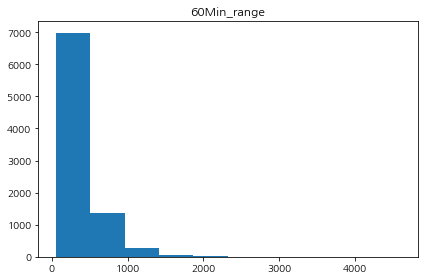

In [11]:
## 전체데이터:  5년(2018.03.05~ 2023.02.28)
## 주가데이터 시간단위 등락율 및 range 산정
close60_df['60분후_종가'] = close60_df['close'].shift(-1)

close60_df['60분후_등락율'] = round(((close60_df['60분후_종가']/close60_df['close'])-1)*100,2)
close60_df['60분후_range'] = close60_df['high'].shift(-1) - close60_df['low'].shift(-1)

## 주가 range의 중간값(median) 찾기
medi_range60 = close60_df['60분후_range'].median()
mean_range60 = close60_df['60분후_range'].mean(axis=0)
std_range60 = close60_df['60분후_range'].std(axis=0)
max_range60 = close60_df['60분후_range'].max(axis=0)
min_range60 = close60_df['60분후_range'].min(axis=0)

print("stats60:","medi_range60",medi_range60,"mean_range60",mean_range60,"std_range60",std_range60, "max_range60",max_range60,
      "min_range60",min_range60)

# 분포
plt.hist(close60_df['60분후_range'])
plt.title('60Min_range')
plt.tight_layout()
plt.show()

#### sample주가 데이터 stats: 전체기간 5년

stats60: medi_range60 300.0 mean_range60 398.78696158323635 std_range60 284.16323435353183 max_range60 4600.0 min_range60 50.0


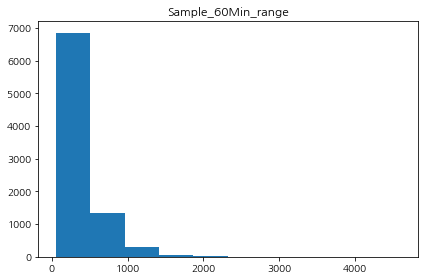

In [12]:
### 전체기간
## Sample data: 5년(2018.03.005~ 2023.02.28)
sample60_df =  close60_df[(close60_df.index >= '2018-03-05 09:00') & (close60_df.index <= '2023-02-28 15:30')] 

## 주가데이터 시간단위 등락율 및 range 산정
sample60_df['60분후_종가'] = sample60_df['close'].shift(-1)

sample60_df['60분후_등락율'] = round(((sample60_df['60분후_종가']/sample60_df['close'])-1)*100,2)
sample60_df['60분후_range'] = sample60_df['high'].shift(-1) - sample60_df['low'].shift(-1)
#print("sample60_df", sample60_df.shape, sample60_df[:5],sample60_df[-5:])

## 주가 range의 중간값(median) 찾기
medi_range60 = sample60_df['60분후_range'].median()
mean_range60 = sample60_df['60분후_range'].mean(axis=0)
std_range60 = sample60_df['60분후_range'].std(axis=0)
max_range60 = sample60_df['60분후_range'].max(axis=0)
min_range60 = sample60_df['60분후_range'].min(axis=0)

print("stats60:","medi_range60",medi_range60,"mean_range60",mean_range60,"std_range60",std_range60, "max_range60",max_range60,
      "min_range60",min_range60)

# 분포
plt.hist(sample60_df['60분후_range'])
plt.title('Sample_60Min_range')
plt.tight_layout()
plt.show()


#### Target 데이터 생성

#### 주가 등락 Label 데이터
1. **등락 label: 종가등락율이 플러스면 1, zero이하 마이너스면 0**
2. **변동성라벨: 설정된 변동성 Range측정기준치 초과이면 1, 이하이면 0**   

#### 주가 변동성 Range측정기준 결정: 
* 6개월 기간단위: median==> 300원선/ 평균 ==> 300~ 400 / 표준편차 ==>  170~240 / 수수료포함 주가 6만원시 이익cutline기준 250원
* 전체5년 기간단위: median==> 300원선/ 평균 ==> 300~ 400 / 표준편차 ==>  210~290 / 수수료포함 주가6만원시 이익cutline기준 250원  
* 변동성측정기준 2개: median기준 >> 상대기준 주가대비 약 0.5%, 절대기준 300원
* **변동성측정기준 결정: 6개월 단위에선 절대기준 300원, 전체기간단위에선 상대기준 0.5%**   
    

#### 측정 시간대
* 시간별 등락율 측정: 매일 5회, 10시, 11시, 12시, 13시, 14시에 1시간후의 종가와 비교하여,상승,하락여부 측정(단, 신년첫날, 수능일과 같이 오전10시 개장일은 오전 11시부터 측정)
* 시간별 변동성(Range)측정: 상기 동일
* 일일 장마감 종가는 미포함: 15시~15시30분으로 30분단위라 미포함

In [13]:
### 전체기간
## 종가등락율이 플러스면 1, zero 이하 마이너스면 0
sample60_df['60분후_등락'] = sample60_df['60분후_등락율'].apply(lambda x: int(1) if x > 0 else int(0))
target60_updn = sample60_df['60분후_등락']
print("target60_updn",target60_updn.shape,target60_updn.head(),target60_updn.tail())
print()

# 변동성측정기준 결정: 전체기간 5년 단위에선 상대기준 0.5% 초과시 1, 같거나 미달시 0' 60분후_range'
sample60_df['60분후_vol'] = sample60_df.apply(lambda x: int(1) if x['60분후_range'] >= x['close']*0.005 else int(0), axis=1)
target60_vol = sample60_df['60분후_vol']
print("target60_vol",target60_vol.shape,target60_vol.head(),target60_vol.tail())
print()


## 매일 장마감 시간대인 15시30분이후 제거(신년초일, 수능일등 오전 10시 개장시 장마감시도 동일하게 15시이후 시간제거)
reg_index60 = [x for x in target60_updn.index if x[-5:-3] < '15']
target60_updn = target60_updn.loc[reg_index60]
print("D target60_updn",target60_updn.shape,target60_updn.head(),target60_updn.tail())
print()

target60_vol = target60_vol.loc[reg_index60]
print("D target60_vol",target60_vol.shape,target60_vol.head(),target60_vol.tail())


target60_updn (8591,) 2018-03-05 10:00    1
2018-03-05 11:00    1
2018-03-05 12:00    1
2018-03-05 13:00    0
2018-03-05 14:00    0
Name: 60분후_등락, dtype: int64 2023-02-28 12:00    1
2023-02-28 13:00    0
2023-02-28 14:00    0
2023-02-28 15:00    0
2023-02-28 15:30    0
Name: 60분후_등락, dtype: int64

target60_vol (8591,) 2018-03-05 10:00    1
2018-03-05 11:00    1
2018-03-05 12:00    0
2018-03-05 13:00    1
2018-03-05 14:00    0
Name: 60분후_vol, dtype: int64 2023-02-28 12:00    0
2023-02-28 13:00    0
2023-02-28 14:00    1
2023-02-28 15:00    0
2023-02-28 15:30    0
Name: 60분후_vol, dtype: int64

D target60_updn (6130,) 2018-03-05 10:00    1
2018-03-05 11:00    1
2018-03-05 12:00    1
2018-03-05 13:00    0
2018-03-05 14:00    0
Name: 60분후_등락, dtype: int64 2023-02-28 10:00    1
2023-02-28 11:00    0
2023-02-28 12:00    1
2023-02-28 13:00    0
2023-02-28 14:00    0
Name: 60분후_등락, dtype: int64

D target60_vol (6130,) 2018-03-05 10:00    1
2018-03-05 11:00    1
2018-03-05 12:00    0
2018-03-05 

                   open   high    low  close   volume  누적체결매도수량  누적체결매수수량  \
2018-03-05 10:00  45820  46160  45140  45280  3924300     47421     31004   
2018-03-05 11:00  45280  45500  45140  45300  1486550     63019     45137   
2018-03-05 12:00  45280  45440  45200  45320  1377200     78189     57511   
2018-03-05 13:00  45320  45380  45180  45360  1041200     87317     69207   
2018-03-05 14:00  45360  45440  45180  45200  1508250    103263     83426   
2018-03-05 15:00  45200  45260  45080  45180  2357400    131609    102228   
2018-03-05 15:30  45180  45220  45120  45200  1611850    139329    125105   
2018-03-06 10:00  45920  46860  45820  46820  5996500     32965     86964   
2018-03-06 11:00  46840  47100  46780  46920  2231650     49764    114798   
2018-03-06 12:00  46920  47000  46660  46800  1311200     61308    129478   

                  60분후_종가  60분후_등락율  60분후_range  60분후_등락  60분후_vol  
2018-03-05 10:00  45300.0      0.04       360.0        1         1  
2018-03-05 11:

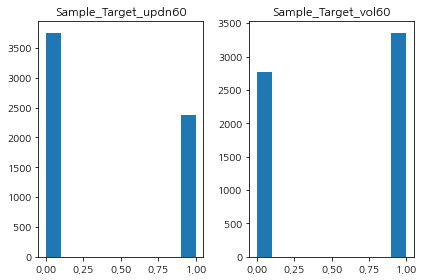

In [14]:
### 전체기간
print(sample60_df[:10])

# target data 분포
plt.subplot(1,2,1)
plt.hist(target60_updn)
plt.title('Sample_Target_updn60')
#plt.show()
plt.subplot(1,2,2)
plt.hist(target60_vol)
plt.title('Sample_Target_vol60')
plt.tight_layout()
plt.show()


#### 클래스 가중치 계산

In [15]:
# 클래스 가중치 계산
class0_updn = [x for x in target60_updn if x ==0]
class1_updn = [x for x in target60_updn if x ==1]
class_updn_rate = round(max(len(class0_updn),len(class1_updn)) / min(len(class0_updn),len(class1_updn)),3)
print("class_updn 개수:",len(target60_updn),len(class0_updn), len(class1_updn),"class_updn_rate",class_updn_rate)
class_updn_weight = {0: 1., 1: class_updn_rate}
print("class_updn_weight",class_updn_weight)

class0_vol = [x for x in target60_vol if x ==0]
class1_vol = [x for x in target60_vol if x ==1]
class_vol_rate = round(max(len(class0_vol),len(class1_vol)) / min(len(class0_vol),len(class1_vol)),3)
print("class_vol 개수:",len(target60_vol),len(class0_vol), len(class1_vol),"class_vol_rate",class_vol_rate)
class_vol_weight = {0: 1., 1: class_vol_rate}
print("class_vol_weight",class_vol_weight)

class_updn 개수: 6130 3755 2375 class_updn_rate 1.581
class_updn_weight {0: 1.0, 1: 1.581}
class_vol 개수: 6130 2771 3359 class_vol_rate 1.212
class_vol_weight {0: 1.0, 1: 1.212}


## 텍스트 데이터 정제 및 전처리:all data shape (1791369, 5) 

#### 전체 데이터(all data shape (1791369, 5)), 샘플데이터 구분( sample shape (234530, 5))

In [16]:
## 전체기간
data_df = saved_data.copy()
print("data_df", data_df.shape, data_df[:5], data_df[-5:])

sample_df = data_df[(data_df['날짜'] >='2018.03.05 09:00') & (data_df['날짜'] <='2023.02.28 15:30')].copy()  #data_df['2022.09.01 09:00':,'날짜'].copy() 
print(sample_df.shape, sample_df[:5], sample_df[-5:])


data_df (1791369, 5)                  날짜                            제목   조회 공감 비공감
0  2017.12.19 10:28                       조루였던게냐.  671  0   0
0  2017.12.19 10:29            내가 어제 오늘260넘는다고 했지  806  2   0
0  2017.12.19 10:33                        호가창 보면  931  2   1
0  2017.12.19 10:39                            외인  772  0   3
0  2017.12.19 10:40  뇌물전자.=휴지조각=건이사망....세금비자금139조  639  0   0                  날짜                                제목   조회 공감 비공감
0  2023.03.22 15:46           친일 반민족행위자 후손들이 살아남는 방법은  144  4   0
0  2023.03.22 15:46                         남한 빨갱이 집단  165  4   9
0  2023.03.22 15:47  사이비 천콩 전광훈JKH 신천지 JMS 검새국암당 한몸뚱이  161  7   0
0  2023.03.22 15:47                        더듬찍 저능아 들아  226  9  15
0  2023.03.22 15:48                        더듬찍 저능아 들아  140  8   2
(1736425, 5)                  날짜                      제목   조회 공감 비공감
0  2018.03.05 09:09  이개잡주가지수내리고ㅋ셀트가 지수 올리네ㅋ  602  2   0
0  2018.03.05 09:10                    징그럽다  678  0   0
0  2018.03.05 09:10           

#### sample 데이터 정제 및 전처리:all data shape (234530, 5) 

#### 전처리

In [17]:
def preprocess_sentence(data_df): 
    # 중복값 제거:  'document'컬럼의 중복값 제거,'label'컬럼은 0,1의 두개면 맞음
    print("Before_중복값개수>> data_df['제목'].duplicated().sum()",data_df['제목'].duplicated().sum(),"전체개수>>:", data_df['제목'].shape)
    if data_df['제목'].duplicated().sum() > 0:
        data_df.drop_duplicates(subset=['제목'], inplace=True) 
        print("Aftre_중복값개수>> data_df['제목'].duplicated().sum()",data_df['제목'].duplicated().sum())    
        print("중복제거후 len(data_df['제목']",len(data_df['제목']))   
    
    ## 결측치제거 : 1개라도 있으면, 해당행 전체 제거
    print("결측치 개수",data_df.isnull().sum())
    if data_df.isnull().any().any():
        data_df.dropna(how='any',inplace=True)
        print("결측치제거후 결측치 여부",data_df.isnull().any().any())    
        
    ## 데이터 정제 
    data_df['제목'] = data_df['제목'].str.strip()
    data_df['제목'] = data_df['제목'].str.replace("[' ']+"," ")
    #data_df['제목'] = data_df['제목'].str.replace("\.{2,30}"," ") 
    data_df['제목'] = data_df['제목'].str.replace("[^ㄱ-힣a-zA-Z0-9!?,.\^+ ^\s]"," ")  
    data_df['제목'] = data_df['제목'].str.replace("\.{2,30}"," ") 
    data_df['제목'] = data_df['제목'].str.replace("[' ']+"," ")
    data_df['제목'] = data_df['제목'].str.strip()
    print("한글과 영어,수치,1칸공백,기타일부 특수기호 등제외후 모두제거상태_data_df.head()",data_df.head())
   
    # 데이터 정제후 공백만 있는 빈문장의 경우 제거:  Nan 입력후 행제거
    print("U 빈문장 개수",data_df['제목'].apply(lambda x: len(str(x)) == 0).sum())    
    if data_df['제목'].apply(lambda x: len(str(x)) == 0).sum() > 0:
        data_df['제목'] =  data_df['제목'].apply(lambda x: x if len(str(x)) > 0 else np.nan) 
    print("D 빈문장 개수",data_df['제목'].apply(lambda x: len(str(x)) == 0).sum())    
    print("D Nan 존재유무",data_df['제목'].isnull().any().any(), data_df.head())
    if data_df['제목'].isnull().any().any():
        data_df.dropna(how='any',axis=0,inplace=True)
    print("Nan제거후 Nan 존재유뮤",data_df['제목'].isnull().any().any() ) 
    print("데이터 전처리후 최종 data_df:", data_df.shape,data_df[:5], data_df[-5:])
    
    return data_df

In [18]:
# 샘플데이터 전처리
sample_temp = preprocess_sentence(sample_df)


Before_중복값개수>> data_df['제목'].duplicated().sum() 263023 전체개수>>: (1736425,)
Aftre_중복값개수>> data_df['제목'].duplicated().sum() 0
중복제거후 len(data_df['제목'] 1473402
결측치 개수 날짜     0
제목     0
조회     0
공감     0
비공감    0
dtype: int64
한글과 영어,수치,1칸공백,기타일부 특수기호 등제외후 모두제거상태_data_df.head()                  날짜                      제목   조회 공감 비공감
0  2018.03.05 09:09  이개잡주가지수내리고ㅋ셀트가 지수 올리네ㅋ  602  2   0
0  2018.03.05 09:10                    징그럽다  678  0   0
0  2018.03.05 09:10                  역시 삼똥이  665  1   0
0  2018.03.05 09:12              아직 198 안왔다  758  1   0
0  2018.03.05 09:12                 오늘 또!!!  776  0   0
U 빈문장 개수 92
D 빈문장 개수 0
D Nan 존재유무 True                  날짜                      제목   조회 공감 비공감
0  2018.03.05 09:09  이개잡주가지수내리고ㅋ셀트가 지수 올리네ㅋ  602  2   0
0  2018.03.05 09:10                    징그럽다  678  0   0
0  2018.03.05 09:10                  역시 삼똥이  665  1   0
0  2018.03.05 09:12              아직 198 안왔다  758  1   0
0  2018.03.05 09:12                 오늘 또!!!  776  0   0
Nan제거후 Nan 존재유뮤 F

In [19]:
## 장중 09~ 14시까지의 데이터만 사용.
print("U sample_temp",sample_temp.shape,)
regular_index = [(i,x) for i,x in enumerate(sample_temp['날짜'].values.tolist()) if x[-5:] >='09:00' and x[-5:] <= '14:00' ]
regular_index = [x[0] for x in regular_index]
print(len(regular_index),regular_index[:10],regular_index[-10:])
sample_temp = sample_temp.iloc[regular_index,:]
print("D sample_temp",sample_temp.shape,sample_temp[:100])   

U sample_temp (1473310, 5)
548616 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [1473224, 1473225, 1473226, 1473227, 1473228, 1473229, 1473230, 1473231, 1473232, 1473233]
D sample_temp (548616, 5)                   날짜                                           제목   조회 공감 비공감
0   2018.03.05 09:09                       이개잡주가지수내리고ㅋ셀트가 지수 올리네ㅋ  602  2   0
0   2018.03.05 09:10                                         징그럽다  678  0   0
0   2018.03.05 09:10                                       역시 삼똥이  665  1   0
0   2018.03.05 09:12                                   아직 198 안왔다  758  1   0
0   2018.03.05 09:12                                      오늘 또!!!  776  0   0
..               ...                                          ...  ... ..  ..
0   2018.03.05 11:00  시립대학교도 좌빨들이 많지 밤에 잠못잔넘들많겄다 비싼돈준다고하고 돈으로 발라라  510  2   5
0   2018.03.05 11:01                  삭제된 게시물의 답글 액분이 주주친화정책이 맞나?  553  2   0
0   2018.03.05 11:02               시간없다 돈으로 막아라 손목댕이 몇년간 붕대로 묶어두고  545  1   3
0   2018.03.05 11:05                  

In [20]:
print("D sample_temp",sample_temp.shape,sample_temp[570:580]) 

D sample_temp (548616, 5)                  날짜                            제목   조회  공감 비공감
0  2018.03.08 09:45                           코스닥  486   0   1
0  2018.03.08 09:45  오늘이나 내일 장초 상승시 털고 가야하나 고민했는데  675   2   2
0  2018.03.08 09:46                          개빡치네  692   1   1
0  2018.03.08 09:48                          갑자기?  636   1   1
0  2018.03.08 09:49                         매물대니까  594   0   3
0  2018.03.08 09:51                  많이는 안내릴것 같아요  623   4   2
0  2018.03.08 09:52                   곧 북미대화 성사된다  535   1   1
0  2018.03.08 09:54                     헛, 밥먹고왔더니  608   3   1
0  2018.03.08 09:55                     다시 올라가네머ㅋ  611   3   1
0  2018.03.08 09:56                       아름다운 조정  773  12   1


###### 정치성향단어들 현황 및 제거

In [21]:
politics = [[i,x] for i,x in enumerate(sample_temp.values) if x[1].find('문재인')!=-1 or x[1].find('문재앙')!=-1 or \
            x[1].find('문죄인')!=-1 or x[1].find('윤석열')!=-1 or x[1].find('윤석렬')!=-1 or \
            x[1].find('이재명')!=-1 or x[1].find('개딸')!=-1 or x[1].find('국민의힘')!=-1 or \
            x[1].find('국힘')!=-1 or x[1].find('더불어민주당')!=-1 or x[1].find('민주당')!=-1 or \
            x[1].find('더불당')!=-1 ]  

print("정치적 단어포함 뎃글수", len(politics))
print("정치문장 최대 글자수", max([len(x[1][1]) for x in politics]))

print("문재인",len([x for x in politics if x[1][1].find('문재인')!=-1 or x[1][1].find('문재앙')!=-1 or x[1][1].find('문죄인')!=-1]))
print("윤석열",len([x for x in politics if x[1][1].find('윤석열')!=-1 or x[1][1].find('윤석렬')!=-1]))
print("이재명",len([x for x in politics if x[1][1].find('이재명')!=-1]))
print()

# 숫자 인덱스로 변경: 0 고정 ==> range index
sample_temp.reset_index(drop= True, inplace=True)
print("전 sample_temp.shape",sample_temp.shape)
politics_idx = [x[0] for x in politics]
print(len(politics_idx))
no_politics_idx = [i for i in sample_temp.index if i not in politics_idx]
print(len(no_politics_idx))
# 정치성향문장 제거 실행
sample_temp1 = sample_temp.loc[no_politics_idx]
print("후 sample_temp1.shape",sample_temp1.shape)    

정치적 단어포함 뎃글수 26900
정치문장 최대 글자수 91
문재인 10775
윤석열 8514
이재명 4524

전 sample_temp.shape (548616, 5)
26900
521716
후 sample_temp1.shape (521716, 5)


###### 문장 빈도수 상위 30개

In [22]:
from collections import Counter
most = Counter([x[1] for x in sample_temp.values]).most_common(30)
print(most)

[('속보', 25), ('아', 25), ('삼성전자', 20), ('삼전', 18), ('하', 16), ('와', 14), ('개미들', 14), ('오늘', 14), ('가즈아', 14), ('긴급 속보', 13), ('음', 13), ('흠', 11), ('공매도', 11), ('6만전자', 11), ('삼성', 10), ('삼성전자는', 10), ('가자', 10), ('이런', 10), ('삼전아', 10), ('연기금', 10), ('코스피', 10), ('야', 10), ('와우', 9), ('외인들', 9), ('야호', 9), ('아니', 9), ('간다', 9), ('5만전자', 9), ('삼만전자', 9), ('재용아', 9)]


#### 텍스트 데이터 정렬방법 분류: 
* 시간당 통 스트링(str)
* 시간당 개별 스트링(str) Timestep

##### 시간당 통 스트링(str)

#### 시간당 통 스트링(str): resample 기법사용시 

In [23]:
print(sample_temp.shape,type(sample_temp.날짜.iloc[0]))

#datetime_str = sample_temp.날짜.iloc[0].replace('.','-')
datetime_str = sample_temp.날짜.str.replace('.','-')
print(datetime_str[:5],datetime_str[-5:])
datetime_object = datetime_str.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M'))

print(type(datetime_object),)
print(len(datetime_object), datetime_object.head())  # printed in default format

sample_temp_tm = sample_temp.copy()
sample_temp_tm['datetime'] = datetime_object
print("@@", sample_temp_tm)
sample_temp_tm = sample_temp_tm[['datetime','제목']]
sample_temp_tm['제목']= sample_temp_tm['제목'].add(' ')
print("resampling 전 sample_temp_tm",sample_temp_tm.shape, sample_temp_tm.head(),sample_temp_tm.tail())
# 시간단위로 resampling
sample_temp_tm = sample_temp_tm.resample(rule='H',closed='left', label='right', on='datetime').sum()
print("resampling 후 sample_temp_tm",sample_temp_tm.shape, sample_temp_tm.head(),sample_temp_tm.tail())
# 시간단위 재정리: resampling하면서, 09~14시외에도 24시간기준으로 빈 시간이 생겨난 것 제거 
regular_index = [(i,x) for i,x in enumerate(sample_temp_tm.index)]
print("시간단위 재정리 전 regular_index",len(regular_index),regular_index[:10],regular_index[-10:])
regular_index = [(i,x) for i,x in enumerate(sample_temp_tm.index) if x.hour >=10 and x.hour <= 14]
print("시간단위 재정리 후 iloc번호&시간쌍 regular_index",len(regular_index),regular_index[:10],regular_index[-10:])
regular_index = [x[0] for x in regular_index]
print("D 시간단위 재정리 후 iloc번호 regular_index",len(regular_index),regular_index[:10],regular_index[-10:])
sample_temp_tm = sample_temp_tm.iloc[regular_index,:]
print("D sample_temp_tm",sample_temp_tm.shape,)   
#print(sample_temp_tm.resample(rule='H',closed='left', label='right', on='datetime').sum())
print(sample_temp_tm.shape,sample_temp_tm.head(10),sample_temp_tm.tail(10))

(548616, 5) <class 'str'>
0    2018-03-05 09:09
1    2018-03-05 09:10
2    2018-03-05 09:10
3    2018-03-05 09:12
4    2018-03-05 09:12
Name: 날짜, dtype: object 548611    2023-02-28 13:58
548612    2023-02-28 13:59
548613    2023-02-28 13:59
548614    2023-02-28 13:59
548615    2023-02-28 14:00
Name: 날짜, dtype: object
<class 'pandas.core.series.Series'>
548616 0   2018-03-05 09:09:00
1   2018-03-05 09:10:00
2   2018-03-05 09:10:00
3   2018-03-05 09:12:00
4   2018-03-05 09:12:00
Name: 날짜, dtype: datetime64[ns]
@@                       날짜                      제목   조회 공감 비공감  \
0       2018.03.05 09:09  이개잡주가지수내리고ㅋ셀트가 지수 올리네ㅋ  602  2   0   
1       2018.03.05 09:10                    징그럽다  678  0   0   
2       2018.03.05 09:10                  역시 삼똥이  665  1   0   
3       2018.03.05 09:12              아직 198 안왔다  758  1   0   
4       2018.03.05 09:12                 오늘 또!!!  776  0   0   
...                  ...                     ...  ... ..  ..   
548611  2023.02.28 13:58       삭제된 

#####  Input/ Label 시간별 짝(Pair)맞추기:  dayindex = stockday = textday ==> 6130개
증시개장일 시간(Hour)기준으로 동일 일자및 동일시간으로 Pairing해야함(댓글데이터는 개장일구분없이 공휴일및 개장시간아닌 시간대에도 많음)

In [24]:
## datetime.weekday() : 월==0, 일==6
# text data 평일 해당 인덱스
print("sample_temp_tm.index", sample_temp_tm.index.shape, sample_temp_tm.index[:10])
week_day = [x for x in sample_temp_tm.index if x.weekday() <= 4]
print(len(week_day), week_day[:10])
week_day = [x.strftime('%Y-%m-%d %H:%M') for x in week_day]  #[str(x)[:-2] for x in week_day]
print(len(week_day), week_day[:10])
textday = week_day.copy()
print()

# 주가 데이터 개장일 인덱스
stockday = target60_updn.index
print(len(stockday), stockday[:10])

# 텍스트데이터 일자와 주가데이터 일자의 날짜 매칭: 증시개장일자 기준
mismatchday = [x for x in textday if x not in stockday] 
#!print("mismatchday",len(mismatchday),mismatchday)

textday = [x for x in textday if x not in mismatchday]
print(len(textday), textday[:10])

# 일치여부 재확인
mismatchday = [x for x in textday if x not in stockday] 
print("일치여부 재확인 mismatchday",len(mismatchday),mismatchday)
print()
# 날짜인덱스 통일
dayindex = stockday = textday
print("dayindex", len(dayindex),dayindex[:5], dayindex[-5:]) 
print()
assert stockday == textday == dayindex

sample_temp_tm.index (9110,) DatetimeIndex(['2018-03-05 10:00:00', '2018-03-05 11:00:00',
               '2018-03-05 12:00:00', '2018-03-05 13:00:00',
               '2018-03-05 14:00:00', '2018-03-06 10:00:00',
               '2018-03-06 11:00:00', '2018-03-06 12:00:00',
               '2018-03-06 13:00:00', '2018-03-06 14:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)
6510 [Timestamp('2018-03-05 10:00:00'), Timestamp('2018-03-05 11:00:00'), Timestamp('2018-03-05 12:00:00'), Timestamp('2018-03-05 13:00:00'), Timestamp('2018-03-05 14:00:00'), Timestamp('2018-03-06 10:00:00'), Timestamp('2018-03-06 11:00:00'), Timestamp('2018-03-06 12:00:00'), Timestamp('2018-03-06 13:00:00'), Timestamp('2018-03-06 14:00:00')]
6510 ['2018-03-05 10:00', '2018-03-05 11:00', '2018-03-05 12:00', '2018-03-05 13:00', '2018-03-05 14:00', '2018-03-06 10:00', '2018-03-06 11:00', '2018-03-06 12:00', '2018-03-06 13:00', '2018-03-06 14:00']

6130 Index(['2018-03-05 10:00', '2018-03-05 11

#### text data / stock data 시간대별 짝(pair)맞추기 완료
* input60_paired_text: 6130    
* target60_paired_updn: 6130    
* target60_paired_vol: 6130

In [25]:
## text data / stock data 시간대별 짝(pair)맞추기 완료
input60_paired_text = sample_temp_tm.loc[dayindex]
target60_paired_updn = target60_updn.loc[dayindex]
target60_paired_vol = target60_vol.loc[dayindex]
print("시간대별 짝 맞춘 input60_paired_text",input60_paired_text.shape,input60_paired_text[:3], input60_paired_text[-3:])
print()
print("시간대별 짝 맞춘 target60_paired_updn",target60_paired_updn.shape,target60_paired_updn[:3], target60_paired_updn[-3:])
print()
print("시간대별 짝 맞춘 target60_paired_vol",target60_paired_vol.shape,target60_paired_vol[:3], target60_paired_vol[-3:])

시간대별 짝 맞춘 input60_paired_text (6130, 1)                                                                     제목
datetime                                                              
2018-03-05 10:00:00  이개잡주가지수내리고ㅋ셀트가 지수 올리네ㅋ 징그럽다 역시 삼똥이 아직 198 안왔다 ...
2018-03-05 11:00:00  셀트 폭락 조짐 보이네 이제부터 아주 조금식 오늘 목표가 분위기상 이번주 이백이십만...
2018-03-05 12:00:00  시립대학교도 좌빨들이 많지 밤에 잠못잔넘들많겄다 비싼돈준다고하고 돈으로 발라라 삭제...                                                                     제목
datetime                                                              
2023-02-28 12:00:00  재명이지지하는 늠들 나의 주적 서민들 어려운데! 검사, 판사 월금을 전액 삭감하라!...
2023-02-28 13:00:00  윤석열 한동훈 검찰 공화국 노 노 노 법과원칙대로라면 다 안다 2찍이들 걸리면 집안...
2023-02-28 14:00:00  정순신 쓰래기 검찰 쓰래기 는 삼전 쓰래기통에 잘알지도 모르면서 아파트 갭투자 년놈...

시간대별 짝 맞춘 target60_paired_updn (6130,) 2018-03-05 10:00    1
2018-03-05 11:00    1
2018-03-05 12:00    1
Name: 60분후_등락, dtype: int64 2023-02-28 12:00    1
2023-02-28 13:00    0
2023-02-28 14:00    0
Name: 60분후_등락, dtype: int64

시간대별 짝 맞춘 target60_pa

In [26]:
## 짝맞춤작업중 댓글이 없는 시간대 819 시간은 댓글이 int인 0로 표시되어있슴, 이를 아래아래 코드에서 '댓글없슴'으로 표시함 
input60_paired_text_int_check = input60_paired_text.loc[:,'제목'].apply(lambda x: x if type(x)==int else 10000)
intCheck = input60_paired_text_int_check[input60_paired_text_int_check !=10000]
print("짝맞춤작업중 댓글없이 int 0으로 채워진 시간대 체크","개수",intCheck.shape, "시간대별 댓글란 모습", intCheck)

짝맞춤작업중 댓글없이 int 0으로 채워진 시간대 체크 개수 (0,) 시간대별 댓글란 모습 Series([], Name: 제목, dtype: int64)


In [27]:
## 댓글이 없는 시간대 819 시간 제거
## datetime index 가 다름: input index는 시간단위 resampling때문에 timestamp이며, target index는 str임(또 10:00:00, 10:00 차이있슴)
delete_list = [x for x in intCheck.index]
print("delete_list",len(delete_list))
delete_list_str = [x.strftime('%Y-%m-%d %H:%M') for x in delete_list]
print("delete_list_str",len(delete_list_str))


## input
input60_paired_text = input60_paired_text.loc[
    [x for x in input60_paired_text.index if x not in delete_list]]
print("input60_paired_text", input60_paired_text.shape,input60_paired_text[:3])

#target
target60_paired_updn = target60_paired_updn[
    [x for x in target60_paired_updn.index if x not in delete_list_str]]

target60_paired_vol = target60_paired_vol[
    [x for x in target60_paired_vol.index if x not in delete_list_str]]

print(len([x for x in target60_paired_updn.index if x not in delete_list_str]))
      
print("댓글없는 시간대 제거 시간대별 짝 맞춘 input60_paired_text",input60_paired_text.shape,
      input60_paired_text[:3], input60_paired_text[-3:])
print()
print("댓글없는 시간대 제거시간대별 짝 맞춘 target60_paired_updn",target60_paired_updn.shape,target60_paired_updn[:3], target60_paired_updn[-3:])
print()
print("댓글없는 시간대 제거 시간대별 짝 맞춘 target60_paired_vol",target60_paired_vol.shape,target60_paired_vol[:3], target60_paired_vol[-3:])


delete_list 0
delete_list_str 0
input60_paired_text (6130, 1)                                                                     제목
datetime                                                              
2018-03-05 10:00:00  이개잡주가지수내리고ㅋ셀트가 지수 올리네ㅋ 징그럽다 역시 삼똥이 아직 198 안왔다 ...
2018-03-05 11:00:00  셀트 폭락 조짐 보이네 이제부터 아주 조금식 오늘 목표가 분위기상 이번주 이백이십만...
2018-03-05 12:00:00  시립대학교도 좌빨들이 많지 밤에 잠못잔넘들많겄다 비싼돈준다고하고 돈으로 발라라 삭제...
6130
댓글없는 시간대 제거 시간대별 짝 맞춘 input60_paired_text (6130, 1)                                                                     제목
datetime                                                              
2018-03-05 10:00:00  이개잡주가지수내리고ㅋ셀트가 지수 올리네ㅋ 징그럽다 역시 삼똥이 아직 198 안왔다 ...
2018-03-05 11:00:00  셀트 폭락 조짐 보이네 이제부터 아주 조금식 오늘 목표가 분위기상 이번주 이백이십만...
2018-03-05 12:00:00  시립대학교도 좌빨들이 많지 밤에 잠못잔넘들많겄다 비싼돈준다고하고 돈으로 발라라 삭제...                                                                     제목
datetime                                                              
2023-02-28 12:00:00  재명이지지하는 

#### 시간당 통 스트링(str): 형태소 분석 및 불용어처리

* 불용어 처리는 Ranks NL에서 제공하는 한국어 불용어사전을 이용: https://www.ranks.nl/stopwords/korean   
* 총 675 단어중 46단어 선정(토큰화후 제일 빈도수 높은 조사등도 포함)  


In [28]:
## 불용어 
#stopwords = pd.read_pickle('./data/korean_stop_word.pickle')
stopwords = ['을', '를', '에', '의', '가', '으로', '로', '에게', '저','는','은', '고','도','게','지', '든간에', '이리하여', '그리하여', '그렇게 함으로써', '앞에서', '중에서', '등', '등등','겨우', '단지', '다만', '와', '과', '왜',
    '야', '이봐', '어이', '여보시오', '흐흐', '흥', '헉헉', '헐떡헐떡', '즉', '들', '그', '기타', '네', '예', '자', '이','으로서']
print(len(stopwords), stopwords)

46 ['을', '를', '에', '의', '가', '으로', '로', '에게', '저', '는', '은', '고', '도', '게', '지', '든간에', '이리하여', '그리하여', '그렇게 함으로써', '앞에서', '중에서', '등', '등등', '겨우', '단지', '다만', '와', '과', '왜', '야', '이봐', '어이', '여보시오', '흐흐', '흥', '헉헉', '헐떡헐떡', '즉', '들', '그', '기타', '네', '예', '자', '이', '으로서']


#### Mecab(), Okt()로 둘 다 사용해봄: 모델 성능에는 거의 비슷하나, Okt가 형태소결과상 증권쪽에 조금 더 나아보여 선택 
Okt: '10000원' ==> '10000원'    
Mecab: '10000원' ==> '10000', '원'

* Okt 소요시간이 Mecab보다 훨씬 많이 걸려서, 형태소분석결과를 저장하고서, 아래 아래 코드서 load하여 사용  

In [ ]:
### 형태소분석,불용어처리
from konlpy.tag import Okt, Mecab   
# tag: 삼성전자 5년치 형태소기준:  Mecab 약30초 소요,    Okt 약 7분소요되나,10000원처럼 조금크게 형태소분석 장점 
# tag 결정할 것 
tag =  'Okt' #'Mecab' 
if tag == 'Okt':
    tokenizer =Okt() 
elif tag == 'Mecab':
    tokenizer = Mecab()
    
stopwords = stopwords
input_tokenized_corpus = []
def build_tokenized_corpus(data_df, tokenizer):
    # 데이터 전처리
    #data_df = preprocess_sentence(data_df)
    #print("data_df", data_df.shape, data_df[:5])
    
    
    # 형태소분석및 불용어처리, 길이1인단어 제거
    for i,sentence in enumerate(tqdm(data_df['제목'].values.tolist())): #enumerate(data_df['제목'].values.tolist()):
        if i%1 == 0 : #i%20000 == 0:
            print(i, sentence)
        # 형태소분석기로 단어 토큰화
        tokenized = tokenizer.morphs(sentence) 
        # 불용어 제거   
        tokenized = [word for word in tokenized if not word in stopwords] # 불용어 제거  
        # 한자(길이1인단어) 제거
        tokenized = [word for word in tokenized if len(word) > 1] # 단어길이 1 짜리 제거  
        input_tokenized_corpus.append(tokenized)
    print("input_tokenized_corpus",len(input_tokenized_corpus), input_tokenized_corpus[:5],input_tokenized_corpus[-5:])
    
    return input_tokenized_corpus

## 1차 토큰화진행 
#input_tokenized_corpus = build_tokenized_corpus(sample_df, tokenizer)        
input_tokenized_corpus = build_tokenized_corpus(input60_paired_text, tokenizer) 

print("형태소분석 완료후_input_tokenized_corpus",len(input_tokenized_corpus),input_tokenized_corpus[:5],input_tokenized_corpus[-5:])

## 형태소분석 완료후 저장: 
save_file= f'../data_morph/input_tokenized_corpus_005930_{tag}.pkl'
joblib.dump(input_tokenized_corpus,save_file+'.gz', compress=('gzip',3))  #0~9: 3은 100%를 약30% 크기로 축소압축, 0은 무압축

    

#### 형태소분석결과 저장분 로드시:  Okt가 소요시간이 7분 정도걸려서, Okt는 한번 분석한 것을 저장해 놓고 사용

In [29]:
#"""
tag =  'Okt' #'Mecab' 

save_file= f'../data_morph/input_tokenized_corpus_005930_{tag}.pkl'
# Okt
if tag == 'Okt':
    #save_file= './data_morph/input_tokenized_corpus_Okt.pkl'
    input_tokenized_corpus = joblib.load(save_file+'.gz')
    print("Okt 저장분 로드", len(input_tokenized_corpus),input_tokenized_corpus[0])

# Mecab 
if tag == 'Mecab':
    #save_file2= './data_morph/input_tokenized_corpus_Mecab.pkl'
    input_tokenized_corpus = joblib.load(save_file+'.gz')
    print("Mecab 저장분 로드", len(input_tokenized_corpus),input_tokenized_corpus[0])
#"""   

Okt 저장분 로드 6130 ['이개', '주가지수', '내리고', '셀트', '지수', '올리네', '징그럽다', '역시', '아직', '198', '왔다', '오늘', '!!!', '했다', '손절', '그냥', '다시', '셀트', '간다', '미친', '삼성', '재수없는', '포디', '설치', '지금', '이라도', '늦음', '삭제', '게시', '물의', '답글', 'null', '삼성', ',,,,', '뇌물', '상납', '상습범', '하나', '이야기', '해줄까', '삼성', '딴건', '오르는데', 'ㅈㄹ', '이네', 'samsung', 'out', '!!!!', '오늘', '같은', '빠지네', '대한민국', '1등', '삼전', '좃됐다', '모르', '파티', 'ㅠㅠ', '박원숭', '재앙', '문정인', '역사왜곡', '하는', '이유', '공산당', '김정은', '숭배', '이기', '때문', '이다', '삼성', '갈려면', '오늘', '5만원', '빠질거지', '진짜', '5만원', '짜리', '되는', 'ㅅㅂ', '가격', '망가지네', '트럼프', '삼전', '손절해', '액면', '분할', '할꺼있냐', '??', '5만원', '떨어지것다', '미친', '주식', '쓰레기', '잡주다', '인들', '그만', '장난', '하시구료', '봉황', '박근혜', '대통령', '아내', '미친', '재앙', '설치니', '나라', '안팎', '에서', '김정은', '숭배', '즉각', '끌어내라고', '아우성', '이다', '이거이거', '????', '막장', '200만원', '언제', '오나요', '설마', '셀트리온', '순위', '바뀌', '절호', '매수', '찬스', '마누라', '빼고', '팔아서', '시장', '가로', '담아라', '오늘', '같은', '빠지면', '다시', '구속', '시켜라', '좋은', '사람', '전자', '끝났는거', '같은데요', '저번', '240', '신의한수', '였네', '모

#### 시간당 통 스트링(str): max_length 설정
* 평균문장길이 509, 표준편차 555, 최대길이 7682, 최소길이 17    
* max_length = 평균 + 2*표준편차 = 1620개    
* 정규분포일 경우, 데이터수의 5%이하 정도만 1620개 초과 형태소가 truncated됨, 총문장수는 변함없슴: padding방식을 'pre','post'양자 다해볼 필요있슴

len_corpus 길이 평균, 표준편차, 최대,최소:  323.73132137030996 348.76831343715446 4787 11
maxlen 1021.2679482446189
maxlen 1021


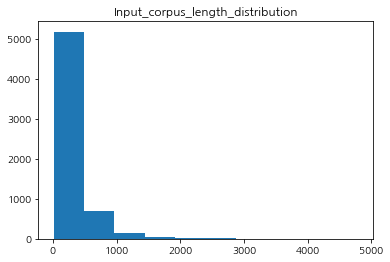

In [30]:
# length list
len_corpus = [len(x) for x in input_tokenized_corpus]

# 데이터 길이 분포 파악
max_length = np.max(len_corpus)
min_length = np.min(len_corpus)
mean_length = np.mean(len_corpus)
std_length = np.std(len_corpus)
print("len_corpus 길이 평균, 표준편차, 최대,최소: ", mean_length, std_length, max_length, min_length)

# maxlen 계산 공식: mean + 2*std 기준으로, 분포도를 보고서, 재량껏 조정
maxlen = mean_length + 2*std_length
print("maxlen", maxlen)
maxlen = int(round(maxlen,0))
print("maxlen", maxlen)

# 분포를 히스토그램으로 보기 plot
plt.hist(len_corpus)
plt.title("Input_corpus_length_distribution")
plt.show()


#### 시간당 통 스트링(str): 정수인덱스 토큰화하기, 보정처리 및 padding >>  'post' <==> 'pre'

In [31]:
#### 정수인덱스 토큰화하기, 보정처리 및 padding
def tokenize(corpus,maxlen= 1519): 
    ## 정수인덱스 토큰화
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token= '<unk>') # oov_token= '<unk>'시'<unk>'가 1로 고정됨 
    tokenizer.fit_on_texts(corpus)
    #[주의!!] 보정처리할 경우에는 texts_to_sequences(corpus)를 보정처리후 padding전에  해야함
    
    ## 보정처리, texts_to_sequences 및 패딩: 
    print("보정전 단어사전 길이:", len(tokenizer.index_word), len(tokenizer.word_index))
    print("보정전 tokenizer.index_word[0~10]",[(k,v) for (k,v) in tokenizer.index_word.items() if k <=30])

    tokenizer.index_word = {k: v for k,v in tokenizer.index_word.items()}
    tokenizer.index_word.update({0:'<pad>'})   # oov_token= '<unk>'시  1:'<unk>'}는 고정되어 있슴  
    # 중복있을 경우 제거: '<unk>',''
    tokenizer.index_word={k:v for k,v in tokenizer.index_word.items() if (k in [0,1]) or  v not in ['<unk>','']}

    tokenizer.word_index = {v: k for k,v in tokenizer.index_word.items()}
    print("보정후 tokenizer.index_word[0~10]",[(k,v) for (k,v) in tokenizer.index_word.items() if k <=30])
    print("tokenizer.index_word",tokenizer.index_word[0],tokenizer.index_word[1],tokenizer.index_word[2])
    print("tokenizer.word_index",tokenizer.word_index['<pad>'],tokenizer.word_index['<unk>'])
       
    # 보정처리완료후texts_to_sequences(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
     
    # 패딩: tf.keras.utils.pad_sequences
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen= maxlen)#maxlen = 19 #padding='post'
    
    #tensor = tf.keras.utils.pad_sequences(tensor,dtype='int32', padding='post', truncating='post', maxlen= maxlen)
    print("보정후 단어사전 길이:", len(tokenizer.index_word), len(tokenizer.word_index))
    
    return tensor, tokenizer

# 정수인덱스 토큰화 및 패딩처리를 완료하여 학습용 데이터를 완성. : 
# updn
print("정수 토크나이징이전 input_tokenized_corpus 개수", len(input_tokenized_corpus))
input_tensor, input_tokenizer = tokenize(input_tokenized_corpus, maxlen= maxlen)
print("정수 토크나이징이후 input_tensor: ", len(input_tensor), input_tensor[:2],input_tensor[-2:],
      "정수 토크나이징이후 한 문장길이== maxlen: ",len(input_tensor[0]))

# 길이가 동일해야함
assert len(input_tokenized_corpus)==len(input_tensor)



정수 토크나이징이전 input_tokenized_corpus 개수 6130
보정전 단어사전 길이: 124610 124610
보정전 tokenizer.index_word[0~10] [(1, '<unk>'), (2, '전자'), (3, '삼성'), (4, '개미'), (5, '삼전'), (6, '오늘'), (7, '주식'), (8, '매수'), (9, '삭제'), (10, '게시'), (11, '물의'), (12, '답글'), (13, '기관'), (14, 'ㅋㅋ'), (15, '이다'), (16, '공매도'), (17, '외인'), (18, '에서'), (19, '지금'), (20, '매도'), (21, 'ㅋㅋㅋ'), (22, '대통령'), (23, '주가'), (24, '까지'), (25, '미국'), (26, '문재인'), (27, '윤석열'), (28, '하는'), (29, '코스피'), (30, '하락')]
보정후 tokenizer.index_word[0~10] [(1, '<unk>'), (2, '전자'), (3, '삼성'), (4, '개미'), (5, '삼전'), (6, '오늘'), (7, '주식'), (8, '매수'), (9, '삭제'), (10, '게시'), (11, '물의'), (12, '답글'), (13, '기관'), (14, 'ㅋㅋ'), (15, '이다'), (16, '공매도'), (17, '외인'), (18, '에서'), (19, '지금'), (20, '매도'), (21, 'ㅋㅋㅋ'), (22, '대통령'), (23, '주가'), (24, '까지'), (25, '미국'), (26, '문재인'), (27, '윤석열'), (28, '하는'), (29, '코스피'), (30, '하락'), (0, '<pad>')]
tokenizer.index_word <pad> <unk> 전자
tokenizer.word_index 0 1
보정후 단어사전 길이: 124611 124611
정수 토크나이징이후 input_tensor:  6130 [[    0     0 

In [32]:
## 클래스 과부족 개수계산
c0_updn_idx = [i for i,x in enumerate(target60_paired_updn) if x ==0]
c1_updn_idx = [i for i,x in enumerate(target60_paired_updn) if x ==1]
c_updn_rate = round(len(c0_updn_idx) / len(c1_updn_idx),3)
over_updn = len(c0_updn_idx) - len(c1_updn_idx)  #3755 2375 
print("c_updn_idx 개수:",len(target60_paired_updn),len(c0_updn_idx), len(c1_updn_idx),"over_updn",over_updn,"c1/c0_updn_rate",c_updn_rate)

c0_vol_idx = [i for i,x in enumerate(target60_paired_vol) if x ==0]
c1_vol_idx = [i for i,x in enumerate(target60_paired_vol) if x ==1]
c_vol_rate = round(len(c1_vol_idx) /len(c0_vol_idx),3)
over_vol = len(c0_vol_idx) - len(c1_vol_idx)  #3711 2419 
print("c_vol 개수:",len(target60_paired_vol),len(c0_vol_idx), len(c1_vol_idx),"over_vol",over_vol,"c1/c0_vol_rate",c_vol_rate)


c_updn_idx 개수: 6130 3755 2375 over_updn 1380 c1/c0_updn_rate 1.581
c_vol 개수: 6130 2771 3359 over_vol -588 c1/c0_vol_rate 1.212


#### 모델구성:
* 임베딩하는 경우:  tf.keras.layers.Embedding()  또는   Word2Vec 
* 임베딩않하는 경우: 정수인덱스토크나이징된 데이터를 그대로 모델에 입력

**임베딩하는 경우: tf.keras.layers.Embedding() 사용의 경우**

#### input 통 시용시

In [33]:
print("단어사전 길이:", len(input_tokenizer.index_word), len(input_tokenizer.word_index))


단어사전 길이: 124611 124611


####  시간통데이터 train,test reset 재분리 및 train, valid 분리 : shuffle 조정

In [34]:
from sklearn.model_selection import train_test_split

x_train0, x_test0, y_train_updn0, y_test_updn0 =train_test_split(input_tensor,target60_paired_updn,
                                                                 test_size=0.15, random_state= 777, shuffle=False, stratify=None)
x_train0, x_test0, y_train_vol0, y_test_vol0 =train_test_split(input_tensor,target60_paired_vol,
                                                               test_size=0.15, random_state= 777, shuffle=False, stratify=None)

print("train0//updn", len(x_train0), len(y_train_updn0), "test0//updn", len(x_test0), len(y_test_updn0), )
print("train0//vol", len(x_train0), len(y_train_vol0), "test0//vol", len(x_test0), len(y_test_vol0), )



train0//updn 5210 5210 test0//updn 920 920
train0//vol 5210 5210 test0//vol 920 920


In [35]:
## train, valid data 분리: 0.85 vs. 0.15
x_train1, x_val1, y_train_updn1, y_val_updn1 =train_test_split(x_train0,y_train_updn0, test_size=0.15, random_state= 777, shuffle=False, stratify=None)
x_train1, x_val1, y_train_vol1, y_val_vol1 =train_test_split(x_train0,y_train_vol0, test_size=0.15, random_state= 777, shuffle=False, stratify=None)

print("train1//updn", len(x_train1),x_train1[0].shape, len(y_train_updn1), 
      "val1//updn", len(x_val1),x_val1[0].shape, len(y_val_updn1), )
print("train1//vol", len(x_train1),x_train1[0].shape, len(y_train_vol1), 
      "val1//vol", len(x_val1),x_val1[0].shape, len(y_val_vol1), )


train1//updn 4428 (1021,) 4428 val1//updn 782 (1021,) 782
train1//vol 4428 (1021,) 4428 val1//vol 782 (1021,) 782


In [36]:
print(x_train1.shape)
print(y_train_updn1.shape,y_train_updn1[-5:])
print(y_train_vol1.shape,y_train_vol1[-5:])

(4428, 1021)
(4428,) 2021-10-13 14:00    1
2021-10-14 10:00    0
2021-10-14 11:00    1
2021-10-14 12:00    1
2021-10-14 13:00    0
Name: 60분후_등락, dtype: int64
(4428,) 2021-10-13 14:00    1
2021-10-14 10:00    1
2021-10-14 11:00    0
2021-10-14 12:00    0
2021-10-14 13:00    1
Name: 60분후_vol, dtype: int64


### LSTM

#### Hyper param Tuning

**[필독: 중요 참고사항]output 고정위한 random_seed 지정시 주의사항**
1. random_seed 를 고정할때, jupyter note book에서는 셀(cell)별로 각각 설정해야함(script는 한번만해도 되지만, 아래 경우엔 for loop 마다 해야함)

2. Hyperparam Tuning시는 튜닝진행중 **모델이 바뀔때마다, 즉, param이 바뀔때마다 for loop내에서, random_seed 새로 지정**해야함, 이것은 jupyter note book과 scriot 공통에서 적용됨

3. 상기 2가지를 지키면, 각 layer마다 initializer의 내부인자 seed를 신경않써도됨 OK (아래 코드내에 initializer를 유지한 이유는,이왕 기재한것 참고하란 의미일 뿐임)

##### 한국어 Word2Vec 임베딩 활용하여 성능 개선

한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용

한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요.

참고 링크1: https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models

참고 링크2: https://radimrehurek.com/gensim/models/keyedvectors.html

##### 사전학습된 embedding layer 인 word2vec_ko.model:  voca size 총 302,960 단어존재, dim 100차원


In [37]:
### 한국어 word2vec 모델: word2vec_ko.model
from gensim.models.keyedvectors import Word2VecKeyedVectors 

word2vec_ko_model_path = '/aiffel/aiffel/[Aiffelthon]textData_stockPrediction_Model/data/word2vec_ko.model'  

word_vectors = Word2VecKeyedVectors.load(word2vec_ko_model_path)
print("word_vectors.wv.vectors.shape:", word_vectors.wv.vectors.shape)
vector = word_vectors.wv['끝']
print('끝_vector', vector[:10])

word_vectors.wv.vectors.shape: (302960, 100)
끝_vector [ 1.038851   -1.1634965   2.2386286   0.8971453  -2.088168   -4.1942534
 -0.02519768 -0.69813883 -0.2908033  -1.4651134 ]


##### similar_by_word 등으로  word2vec_ko.model테스트: 
-similar_by_word: 인공지능, 하정우, 미분, 삼성전자,막걸리 5단어검색결과 모두 유사단어 매칭됨 

-most_similar: positive=['웃음', '기쁨'], negative=['슬픔']으로 해봤는데, 상당히 유사한 '즐거움'으로 나오며, 유사도 0.7928로 높음

-distance: ("짜장면", "짜장면"): 0.0 으로 동일하다는 의미임 //   ("개울", "비트코인"): 1.2 로 관련성이 멀다는 의미


In [38]:
# shape
print(word_vectors.wv.vectors.shape)

# similar_by_word 테스트
vector = word_vectors.wv.similar_by_word('인공지능')
print('인공지능_vector',vector)

# most_similar / similarity
result = word_vectors.wv.most_similar(positive=['웃음', '기쁨'], negative=['슬픔'])
most_similar_key, similarity = result[0]  # look at the first match
print(f"{most_similar_key}: {similarity:.4f}")

# distance
distance = word_vectors.wv.distance("짜장면", "짜장면")
print(f"{distance:.1f}")
distance = word_vectors.wv.distance("개울", "비트코인")
print(f"{distance:.1f}")

(302960, 100)
인공지능_vector [('AI', 0.8461811542510986), ('컴퓨팅', 0.7893764972686768), ('가상현실', 0.7639997601509094), ('컴퓨터', 0.7492972016334534), ('IT', 0.7431951761245728), ('블록체인', 0.7353136539459229), ('솔루션', 0.7322530746459961), ('기술', 0.7209259867668152), ('로봇', 0.7138662338256836), ('ICT', 0.7124600410461426)]
즐거움: 0.7928
0.0
1.2


##### 하이퍼파람튜닝 및 word2vec Embedding 사용

embedding_matrix [[0.15266373 0.30235661 0.06203641 0.45986034 0.83525338 0.92699705
  0.72698898 0.76849622 0.26920507 0.64402929 0.09337326 0.07968589
  0.58961375 0.34334054 0.98887615 0.62647321 0.68177928 0.55225681
  0.26886006 0.37325939 0.2229281  0.1864426  0.39064809 0.19316241
  0.61091093 0.88280845 0.62233882 0.25311894 0.17993031 0.81640447
  0.22537162 0.51685714 0.51849582 0.60037494 0.53262048 0.01331005
  0.52409726 0.89588471 0.76990129 0.1228517  0.29587269 0.61202358
  0.72613812 0.46349747 0.76911037 0.19163103 0.55786672 0.55077816
  0.47222549 0.79188496 0.11524968 0.6813039  0.36233361 0.34420889
  0.44951875 0.02694226 0.41524769 0.9222317  0.09120557 0.31512178
  0.52802224 0.32806203 0.44891554 0.01633442 0.0970269  0.69258857
  0.83594341 0.42432199 0.8487743  0.54679121 0.35410346 0.72724968
  0.09385168 0.8928588  0.33625828 0.89183268 0.296849   0.30164829
  0.80624061 0.83760997 0.63428133 0.3113273  0.02944858 0.39977732
  0.51817346 0.00738845 0.77494

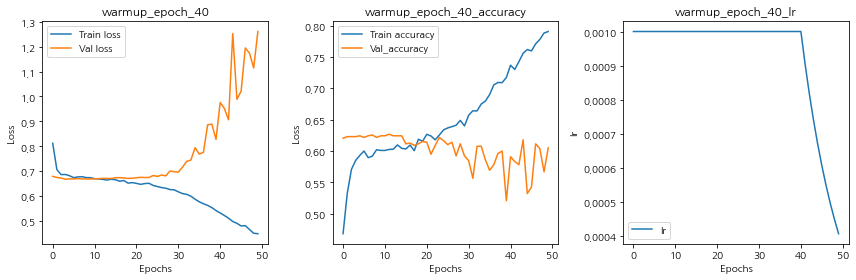

warmup_epoch_Best_val_param 40 warmup_epoch_Best_val_accuracy 0.6048593521118164
Best_hpname_param_list 1 [['warmup_epoch', '40', 0.6048593521118164]]


In [39]:
from tensorflow.keras.initializers import Constant

# random sed 고정
seed = 777
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# 임베딩레이어의 random_seed 고정: embedding_initializer의 'uniform'은 GlorotUniform이라함(chatGPT에질문)
gloruniform_init = tf.keras.initializers.GlorotUniform(seed= seed)
ortho_init= tf.keras.initializers.Orthogonal(seed=seed)


## 하이퍼 튜닝_학습
#2023.4.26. top
"""
vocab_size = 30000 #len(input_tokenizer.word_index) #30000   # 어휘 사전의 크기(38710)  #10,000개의 단어)
word_vector_dim = 100 #256   # 워드 벡터의 차원 수
hidden_unit = 128
drop_rate = 0.2#5 
lr = 0.001 #0.00001  #0.1 #0.000001 #0.1 #00001 

factor = 0.3   #plateau
patience = 5

#warmup_epoch = 30 #30    # custom def
beta_1=0.9       #adam
beta_2=0.999     #adam
optimizer = 'adam' #'rmsprop'  #'adam'
batch_size = 32  #256 #32 
epochs= 50 #100 #50 
warmup_epoch = int(epochs*0.6)  
"""


# Hyperparameters
cls_weight = 1.581
vocab_size = 50000 #len(input_tokenizer.word_index) #30000 #l 
word_vector_dim = 100  #256 
hidden_unit = 128 # 64도 양호
drop_rate = 0.5 #0.2#5 
lr = 0.001  #0.000001 #0.05  #0.00001 #0.001  

factor= 0.3               #plateau
patience=4                #plateau

warmup_epoch = 30         #custom 
estop_patience = 3
beta_1=0.9               #adam
beta_2=0.999             #adam
rms_rho = 0.9           #rmsprop
rms_mtum = 0.0           #rmsprop
optimizer = 'rmsprop'#'adam' #''rmsprop' #'adam' #'rmsprop'  
estop_patience = 3
batch_size = 512 #32  # 순위가 512 > 256 > 32 의 3개가 58%대로 서로비슷하며 근소한차이인데, 512,256이 당연히 변동성적음,  #512
epochs= 50 # 10 이 62%이나, 라벨분포따른 것 같음 
warmup_epoch = int(epochs*0.8)         #custom

#Best: voca 30000(793,127/, 60.38, 59.46) // word_vec 256(783,137/, 60.35, 59.86)// hunit 128 (  )//drop 0.5/lr 0.00001 
#==>((920 794 126/val 59.87,- test accuracy: 0.5935))//

## word2vec_ko.model을 [[ LSTM모델 ]] 의 임베딩레이어의 초기화가중치로 사용
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
for i in range(2,vocab_size):        # embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피
    if input_tokenizer.index_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[input_tokenizer.index_word[i]]        
print("embedding_matrix",embedding_matrix[:1],embedding_matrix.shape)   # (10000,100)    



#### LSTM 모델
# LSTM 모델설정
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, mask_zero= False,
                                         embeddings_initializer=Constant(embedding_matrix), # embeddings_initializer=gloruniform_init,
                                         trainable=True,                   # trainable을 True로 주면 Fine-tuning                                         
                                         input_shape=(x_train1.shape[1],)))
model_lstm.add(tf.keras.layers.BatchNormalization()) 
model_lstm.add(tf.keras.layers.Dropout(drop_rate))
model_lstm.add(tf.keras.layers.LSTM(hidden_unit)) #, kernel_initializer=gloruniform_init,recurrent_initializer=ortho_init,)) 
#model_lstm.add(tf.keras.layers.LSTM(hidden_unit,input_shape=(1, x_train1.shape[2])))
model_lstm.add(tf.keras.layers.BatchNormalization())
model_lstm.add(tf.keras.layers.Dropout(drop_rate))
model_lstm.add(tf.keras.layers.Dense(hidden_unit)) #, kernel_initializer=gloruniform_init))
model_lstm.add(tf.keras.layers.BatchNormalization())
model_lstm.add(tf.keras.layers.LeakyReLU(alpha=0.3))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid')) 
model_lstm.summary()


## Hyper param tuning : hparam 한개씩 해서,search space 구성후, accuracy가 제일 높은 param을 1차 자동선택후,다음 param 진행  
# hpname list 설정
hp_name_list = ['warmup_epoch',]   

# search space 설정: param 설정
cls_weight_list = [1.2, 1.3, 1.4, 1.5, 1.581, 1.7]
vocab_size_list = [10000, 20000,30000,50000]
word_vector_dim_list = [30, 50,70,100]  #64, 128 ,256, 512]
hidden_unit_list = [32, 64, 128, 256,512]
drop_rate_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
lr_list = [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00001,0.000001] #plateau

factor_list = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]   #plateau
patience_list = [3, 4, 5, 7, 10]

warmup_epoch_list =[int(epochs* 0.8),]# [int(epochs* 0.2), int(epochs*0.3),int(epochs*0.4),int(epochs*0.5), int(epochs*0.6), int(epochs*0.7), int(epochs*0.8)] # custom def
estop_patience_list = [2, 3, 4, 5, 7, 10]
beta_1_list = [0.7, 0.8, 0.85, 0.9, 0.95]   #adam 0.9
beta_2_list= [0.8, 0.85, 0.9, 0.95, 0.999]   #adam 0.999batch_size
optimizer_list = ['adam','rmsprop',]# 'adam']
rms_rho_list = [0.8, 0.85, 0.87, 0.9, 0.93, 0.95, 0.99]           #rmsprop
rms_mtum_list = [0.0, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99]           #rmsprop
estop_patience_list = [2, 3 ,4, 5, 7]
batch_size_list = [32, 64, 128, 256, 512]
epochs_list= [10, 30, 50, 80, 100, 200]
#warmup_epoch_list

#### 금번 Tuning 대상 설정
total_hyperparam_list = [warmup_epoch_list]

# 필요 list
hyperparam_list = []
Best_hpname_param_list = []

# 학습 Histoty Dict 설정
tuning_log={}

## lr scheduler 및 callbacks
def scheduler(epoch):
    if epoch < warmup_epoch:
        return lr
    else:
        return lr * tf.math.exp(0.1 * (warmup_epoch - epoch))

# Hyper param Tuning 실행
for ix, hpname in enumerate(hp_name_list):
    tuning_log[hpname]={}
    hyperparam_list = total_hyperparam_list[ix]    
    for i, param in enumerate(hyperparam_list):
        print("i", i, "param", param, "hpname", hpname)
        tuning_log[hpname][f'{param}']= {}  

        del model_lstm
               
        # param
        cls_weight = cls_weight
        vocab_size = vocab_size  
        word_vector_dim = word_vector_dim 
        hidden_unit = hidden_unit  
        drop_rate = drop_rate 
        lr = lr  
        factor = factor               #plateau
        patience = patience                #plateau
        warmup_epoch = param #warmup_epoch    #custom 
        estop_patience = estop_patience
        beta_1= beta_1               #adam
        beta_2= beta_2   
        optimizer =  optimizer 
        rms_rho = rms_rho        #rmsprop
        rms_mtum = rms_mtum      #rmsprop
        estop_patience = estop_patience
        batch_size = batch_size
        epochs= epochs 
        
        # 클래스 가중치 계산:
        #class_updn_weight= {0: 1.0, 1: cls_weight}  #1.581}
        
        ## word2vec_ko.model을 [[ LSTM모델 ]] 의 임베딩레이어의 초기화가중치로 사용
        if hpname in ['vocab_size','word_vector_dim']:
            embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
            for i in range(2,vocab_size):        # embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피
                if input_tokenizer.index_word[i] in word_vectors.wv:
                    embedding_matrix[i] = word_vectors.wv[input_tokenizer.index_word[i]]     
            print("embedding_matrix",embedding_matrix[:1],embedding_matrix.shape)   # (10000,100)    
        
                    
        # LSTM 모델설정  
        # random sed 고정
        seed = 777
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
        
        model_lstm = tf.keras.Sequential()
        model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, mask_zero= False, # True,
                                                 embeddings_initializer=Constant(embedding_matrix),
                                                 trainable=True,                   # trainable을 True로 주면 Fine-tuning
                                                 input_shape=(x_train1.shape[1],)))
        model_lstm.add(tf.keras.layers.BatchNormalization()) 
        model_lstm.add(tf.keras.layers.Dropout(drop_rate))
        model_lstm.add(tf.keras.layers.LSTM(hidden_unit)) #, kernel_initializer=gloruniform_init,recurrent_initializer=ortho_init,)) 
        #model_lstm.add(tf.keras.layers.LSTM(hidden_unit,input_shape=(1, x_train1.shape[2])))
        model_lstm.add(tf.keras.layers.BatchNormalization())
        model_lstm.add(tf.keras.layers.Dropout(drop_rate))
        model_lstm.add(tf.keras.layers.Dense(hidden_unit)) #, kernel_initializer=gloruniform_init))
        model_lstm.add(tf.keras.layers.BatchNormalization())
        model_lstm.add(tf.keras.layers.LeakyReLU(alpha=0.3))
        model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        model_lstm.summary()

        
        ## lr scheduler 및 callbacks
        def scheduler(epoch):
            if epoch < warmup_epoch:
                return lr
            else:
                return lr * tf.math.exp(0.1 * (warmup_epoch - epoch))
            
        # callback   
        cb_lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= factor, patience=patience, verbose=0, mode='auto', min_delta=0.0001,
                           cooldown=0, min_lr=0)
        cb_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
        cb_chkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='../model/check_point/checkpoint.{epoch:02d}.hdf5',
                                                         monitor='val_loss',mode='min',save_best_only= True, save_weights_only=True,save_freq='epoch')
        cb_early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=estop_patience, mode='min')
        log_dir= '../logs/log'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        cb_tboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq='epoch')
        
        # optimizer
        if optimizer == 'rmsprop':
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr, rho=0.9,  momentum=rms_mtum,  epsilon=1e-07) #0.001
        elif optimizer == 'adam':    
            optimizer =tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999,  epsilon=1e-07) #0.001
        
        # loss function    
        binary_crossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy')  
        
        model_lstm.compile(optimizer= optimizer, loss=binary_crossentropy, metrics=['accuracy']) 
        
        # 학습 실행
        history_lstm = model_lstm.fit(x_train1, y_train_updn1, epochs=epochs, callbacks=[cb_lr,cb_chkpoint,], 
               batch_size=batch_size, validation_data=(x_val1, y_val_updn1), verbose=1)
        
        tuning_log[hpname][f'{param}']=  history_lstm.history                            
        #!print(f"tuning_log[hpname][f'{param}']",tuning_log[hpname][f'{param}'])
        
        # plot        
        print("history_lstm",history_lstm.history.keys())                        
        loss1 = history_lstm.history['loss']
        valloss1 = history_lstm.history['val_loss']
        accu1 = history_lstm.history['accuracy']
        valaccu1 = history_lstm.history['val_accuracy']
        lr1 = history_lstm.history['lr']
        
        # LOSS
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.plot(range(len(loss1)), loss1, label='Train loss')
        plt.plot(range(len(loss1)), valloss1, label='Val loss')
        plt.title(f'{hpname}_{param}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        # ACCURACY
        plt.subplot(1,3,2)
        plt.plot(range(len(loss1)), accu1, label='Train accuracy')
        plt.plot(range(len(loss1)), valaccu1, label='Val_accuracy')
        plt.title(f'{hpname}_{param}_accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        # Lr
        plt.subplot(1,3,3)
        plt.plot(range(len(loss1)), lr1, label='lr')
        plt.title(f'{hpname}_{param}_lr')
        plt.xlabel('Epochs')
        plt.ylabel('lr')
        plt.legend()
        plt.tight_layout()
        plt.show()
       
        del history_lstm
        
    # Best_param 선택 
    last_valaccu = []
    for i,(k,v) in enumerate(tuning_log[hpname].items()):
        last_valaccu.append([i, k, v['val_accuracy'][-1]])   # 'val_accuracy'
    Best_val_set = sorted(last_valaccu, key=lambda x: x[2],reverse= True)[0]  #  reverse= True ==descending 
    Best_val_accuracy = Best_val_set[2] 
    Best_val_param= Best_val_set[1]    
    print(hpname+"_Best_val_param", Best_val_param, hpname+"_Best_val_accuracy", Best_val_accuracy)   # epoch는 0부터시작하는 숫자
   
    # hpname별 Best_param 집계
    Best_hpname_param_list.append([hpname, Best_val_param, Best_val_accuracy])
    
print("Best_hpname_param_list",len(Best_hpname_param_list),Best_hpname_param_list)
                                   
# 저장
tuning_log_df = pd.DataFrame(tuning_log)
tuning_log_df.to_pickle(f'/aiffel/aiffel/[Aiffelthon]textData_stockPrediction_Model/hparam_tuning_data/tuning_log_{hpname}')

df = pd.DataFrame(Best_hpname_param_list)  
df.to_pickle(f'/aiffel/aiffel/[Aiffelthon]textData_stockPrediction_Model/hparam_tuning_data/Best_hpname_param_list_{hpname}')


920 827 93
920 564 356


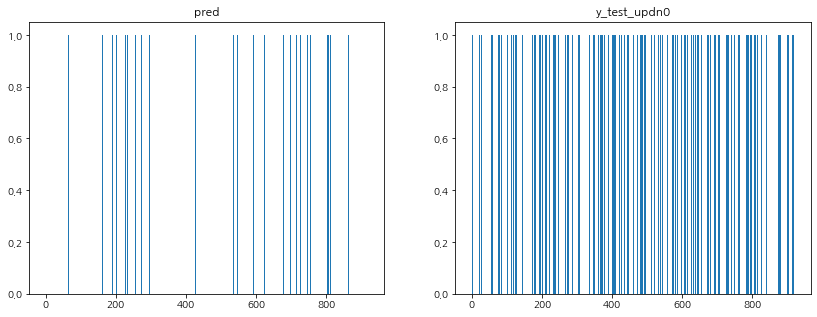

  
test data 로 LSTM 모델 성능평가 ------------------------------------------------------------------------------------------
29/29 - 1s - loss: 1.1651 - accuracy: 0.5793
results_lstm [1.1651461124420166, 0.5793478488922119]


In [40]:
## label 분포
pred = model_lstm.predict(x_test0) #,  y_test_vol0, verbose=2)
print(len(pred),len([x for x in pred if x <= 0.5]),len([x for x in pred if x > 0.5]))
print(len(y_test_updn0),len([x for x in y_test_updn0 if x <= 0.5]), len([x for x in y_test_updn0 if x > 0.5]))

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
#print(len([0 if x <= 0.5 else 1 for x in pred]),[0 if x <= 0.5 else 1 for x in pred][:50])
plt.bar(range(len(y_test_updn0)),[0 if x <= 0.5 else 1 for x in pred])
plt.title('pred')
plt.subplot(1,2,2)
plt.bar(range(len(y_test_updn0)),y_test_updn0)
plt.title('y_test_updn0')
plt.show()

## LSTM 모델 성능평가
print("  ")
print("test data 로 LSTM 모델 성능평가", "---"*30)
results_lstm = model_lstm.evaluate(x_test0,  y_test_updn0, verbose=2)
#results_lstm = model_lstm.evaluate(x_test0,  y_test_vol0, verbose=2)
print("results_lstm", results_lstm)

#### f1score, confusion matrix:  [GDeep]04_[reuter_classification_ML8개비교]
classification_report:       
macro: 단순평균    
weighted: 각 클래스에 속하는 표본의 개수로 가중평균   
accuracy: 정확도. 전체 학습 데이터의 개수에서 클래스를 정확하게 맞춘 개수의 비율

In [42]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model_lstm.predict(x_test0) #,  y_test_vol0, verbose=2)
y_pred = [1 if x > 0.5 else 0 for x in pred]
#macro: 단순평균 /weighted: 각 클래스에 속하는 표본의 개수로 가중평균/accuracy: 정확도. 전체 학습 데이터의 개수에서 클래스를 정확하게 맞춘 개수의 비율
print(classification_report(y_test_updn0, y_pred, zero_division=0))
#print(confusion_matrix(y_test_updn0, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.89      0.72       564
           1       0.33      0.09      0.14       356

    accuracy                           0.58       920
   macro avg       0.47      0.49      0.43       920
weighted avg       0.50      0.58      0.50       920



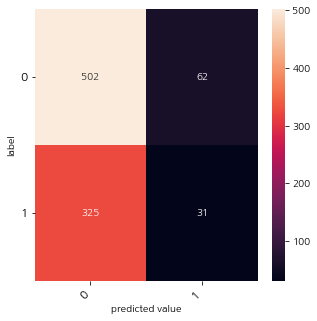

In [43]:
def graph_confusion_matrix(y_test, y_pred):#, classes_name):
  df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred))#, index=classes_name, columns=classes_name)
  fig = plt.figure(figsize=(5,5))
  heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
  plt.ylabel('label')
  plt.xlabel('predicted value')

graph_confusion_matrix(y_test_updn0, y_pred)

#### 수익성 계산
크레온기준     
주식매매 수수료: 온라인 0.015% / 코스피: 거래세 0.05% + 농특세 0.15% == 0.20% / 코스닥:거래세 0.20% == 0.20%          
* 매수,매도 1회전시 소요비용: 0.015*2 + 0.2 == 0.23%,  슬리피지: 6만원기준 1tick 100원기준 1.0틱 예상 == 약 0.085%
* 매수,매도 1회전시 총소요비용: 약 0.315% (6만원기준 189원) 

주식선물매매수수료 온라인 : 0.006%, 거래세없슴
* 매수,매도 1회전시 소요비용: 0.006*2 == 0.012%,  슬리피지: 6만원기준 1tick 100원기준 선물은 0.5틱예상 == 약 0.085%
* 매수,매도 1회전시 총소요비용: 약 0.1% (6만원기준 60원) 

매매 원칙: profit target 5%, trailingStop 0.6, basefloor 0.8%, losscut: - 0.8%, 

In [44]:
## 테스트데이터 수익성계산
# 기본데이터:  sample60_df(8591,12)
print("기본데이터/sample60_df",sample60_df.shape, sample60_df.columns)
target60_paired_root= sample60_df.loc[target60_paired_updn.index,['close','60분후_종가','60분후_등락율','60분후_등락']]
print("개장일데이터/target60_paired_root",target60_paired_root.shape)

# 전체 상승시점 데이터
target60_paired_root00pcnt = target60_paired_root[target60_paired_root['60분후_등락율'] > 0]
target60_paired_root0315pcnt = target60_paired_root[target60_paired_root['60분후_등락율'] >= 0.315]
print("전체데이터중 상승시점데이터",target60_paired_root00pcnt.shape,
      "전체데이터중 상승 0.315% 데이터", target60_paired_root0315pcnt.shape)         

# 테스트데이터중 상승시점/하락시점데이터
target60_paired_root_testdata = target60_paired_root[-920:]
target60_paired_root00pcnt_testdata = target60_paired_root_testdata[target60_paired_root_testdata['60분후_등락율'] > 0]
target60_paired_root00pcnt_testdata_dn = target60_paired_root_testdata[target60_paired_root_testdata['60분후_등락율'] <= 0]
target60_paired_root0315pcnt_testdata = target60_paired_root_testdata[target60_paired_root_testdata['60분후_등락율'] >= 0.315]
print("테스트데이터중 상승시점데이터",target60_paired_root00pcnt_testdata.shape,
      "테스트데이터중 하락시점데이터",target60_paired_root00pcnt_testdata_dn.shape,
      "테스트데이터중 상승 0.315% 데이터",target60_paired_root0315pcnt_testdata.shape)         

## 테스트데이터중 상승예측데이터 인덱스???
pred = model_lstm.predict(x_test0) #,  y_test_vol0, verbose=2)
pred_up_idx= [i for i,x in enumerate(pred) if x > 0.5]
pred_dn_idx= [i for i,x in enumerate(pred) if x <= 0.5]
print("pred_up_idx",len(pred),len(pred_up_idx),pred_up_idx[:30])
print("pred_dn_idx",len(pred),len(pred_dn_idx),pred_dn_idx[:30])

기본데이터/sample60_df (8591, 12) Index(['open', 'high', 'low', 'close', 'volume', '누적체결매도수량', '누적체결매수수량',
       '60분후_종가', '60분후_등락율', '60분후_range', '60분후_등락', '60분후_vol'],
      dtype='object')
개장일데이터/target60_paired_root (6130, 4)
전체데이터중 상승시점데이터 (2375, 4) 전체데이터중 상승 0.315% 데이터 (1034, 4)
테스트데이터중 상승시점데이터 (356, 4) 테스트데이터중 하락시점데이터 (564, 4) 테스트데이터중 상승 0.315% 데이터 (190, 4)
pred_up_idx 920 93 [15, 42, 44, 53, 55, 64, 65, 72, 99, 124, 162, 164, 180, 184, 186, 191, 192, 202, 203, 228, 233, 255, 256, 257, 261, 263, 269, 273, 280, 296]
pred_dn_idx 920 827 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [45]:
target60_paired_root_copy = copy.deepcopy(target60_paired_root)
target60_paired_root_copy['120분후 종가'] = target60_paired_root_copy['close'].shift(-2)
target60_paired_root_copy['180분후 종가'] = target60_paired_root_copy['close'].shift(-3)
target60_paired_root_copy['240분후 종가'] = target60_paired_root_copy['close'].shift(-4)
print(target60_paired_root_copy.head(6))

                  close  60분후_종가  60분후_등락율  60분후_등락  120분후 종가  180분후 종가  \
2018-03-05 10:00  45280  45300.0      0.04        1   45320.0   45360.0   
2018-03-05 11:00  45300  45320.0      0.04        1   45360.0   45200.0   
2018-03-05 12:00  45320  45360.0      0.09        1   45200.0   46820.0   
2018-03-05 13:00  45360  45200.0     -0.35        0   46820.0   46920.0   
2018-03-05 14:00  45200  45180.0     -0.04        0   46920.0   46800.0   
2018-03-06 10:00  46820  46920.0      0.21        1   46800.0   46880.0   

                  240분후 종가  
2018-03-05 10:00   45200.0  
2018-03-05 11:00   46820.0  
2018-03-05 12:00   46920.0  
2018-03-05 13:00   46800.0  
2018-03-05 14:00   46880.0  
2018-03-06 10:00   46960.0  


In [47]:
## 개략적 수익률 계산   #2
target60_paired_root_copy_testdata = target60_paired_root_copy[-920:]
target60_pred_up_testdata = target60_paired_root_copy_testdata.iloc[
    pred_up_idx,[0,1,4,5,6]]
print("target60_pred_up_testdata",target60_pred_up_testdata.shape, target60_pred_up_testdata.head())

m60list=[]
m120list=[]
m180list=[]
m240list=[]

#0.015% / 코스피: 거래세 0.05% + 농특세 0.15% /슬리피지: 6만원기준 1tick 100원기준 == 약 0.17%
for i,(dt,(close, m60, m120, m180, m240)) in enumerate(target60_pred_up_testdata.iterrows()):
    close = float(close); m60=float(m60); m120=float(m120); m180=float(m180);m240=float(m240);
    if i%100==0:
        print(i, dt, close, m60, m120, m180, m240)
    # m60
    if dt[-5:] >= '10:00'  and dt[-5:] <= '12:00'  and (m180 is not None and np.isnan(m60)== False) :
        profit = m60 - close
        total_cost = (close*0.015 + m60*0.215 + (close+m60)*0.5*0.085)/100
        net_profit = profit - total_cost
        ratio = round((net_profit / close)*100,2)
        m60list.append([dt,close,m60,profit, total_cost,net_profit,ratio])
        
    # m120
    if dt[-5:] >= '10:00'  and dt[-5:] <= '13:00' and (m120 is not None and np.isnan(m120)== False) :
        profit = m120 - close
        total_cost = (close*0.015 + m120*0.215 + (close+m120)*0.5*0.085)/100
        net_profit = profit - total_cost
        ratio = round((net_profit / close)*100,2)
        m120list.append([dt,close,m120,profit, total_cost,net_profit,ratio])
    # m180
    if dt[-5:] >= '10:00'  and dt[-5:] <= '14:00' and (m180 is not None and np.isnan(m180)== False):
        profit = m180 - close
        total_cost = (close*0.015 + m180*0.215 + (close+m180)*0.5*0.085)/100
        net_profit = profit - total_cost
        ratio = round((net_profit / close)*100,2)
        m180list.append([dt,close,m180, profit, total_cost,net_profit,ratio])
    # m240 
    if (m240 is not None and np.isnan(m240)== False):
        profit = m240 - close
        total_cost = (close*0.015 + m240*0.215 + (close+m240)*0.5*0.085)/100
        net_profit = profit - total_cost
        ratio = round((net_profit / close)*100,2)
        m240list.append([dt,close,m240, profit, total_cost,net_profit,ratio])
    
    

m60list = np.array(m60list, dtype=object) 
print(m60list[0])
print("m60list", m60list.shape,"profit_mean", np.mean(m60list[:,3]),"total_cost_mean", 
      np.mean(m60list[:,4]),"net_profit_mean",np.mean(m60list[:,5]),"수익률평균",np.mean(m60list[:,6]))
print()
m120list = np.array(m120list, dtype=object) 
print("m120list", m120list.shape,"profit_mean", np.mean(m120list[:,3]),"total_cost_mean", 
      np.mean(m120list[:,4]),"net_profit_mean",np.mean(m120list[:,5]),"수익률평균",np.mean(m120list[:,6]))      
print()
m180list = np.array(m180list, dtype=object) 
print("m180list", m180list.shape,"profit_mean", np.mean(m180list[:,3]),"total_cost_mean", 
      np.mean(m180list[:,4]),"net_profit_mean",np.mean(m180list[:,5]),"수익률평균",np.mean(m180list[:,6]))       
print()
m240list = np.array(m240list, dtype=object) 
print("m240list", m240list.shape,"profit_mean", np.mean(m240list[:,3]),"total_cost_mean", 
      np.mean(m240list[:,4]),"net_profit_mean",np.mean(m240list[:,5]),"수익률평균",np.mean(m240list[:,6]))



target60_pred_up_testdata (93, 5)                   close  60분후_종가  120분후 종가  180분후 종가  240분후 종가
2022-06-08 13:00  65500  65300.0   64700.0   64800.0   64600.0
2022-06-16 10:00  61600  61200.0   61100.0   61300.0   60800.0
2022-06-16 12:00  61100  61300.0   60800.0   59800.0   59800.0
2022-06-20 11:00  58200  58300.0   58300.0   58100.0   58500.0
2022-06-20 13:00  58300  58100.0   58500.0   58500.0   58300.0
0 2022-06-08 13:00 65500.0 65300.0 64700.0 64800.0 64600.0
['2022-06-16 10:00' 61600.0 61200.0 -400.0 193.01 -593.01 -0.96]
m60list (55, 7) profit_mean 5.454545454545454 total_cost_mean 189.16868181818177 net_profit_mean -183.7141363636363 수익률평균 -0.3021818181818184

m120list (78, 7) profit_mean 41.02564102564103 total_cost_mean 189.58621794871792 net_profit_mean -148.5605769230769 수익률평균 -0.2348717948717951

m180list (93, 7) profit_mean 6.451612903225806 total_cost_mean 189.00645161290325 net_profit_mean -182.5548387096774 수익률평균 -0.2933333333333334

m240list (92, 7) profit_mean -23.

#### Back Test

In [48]:
import backtrader as bt
import pandas as pd
import pickle
from sklearn.preprocessing import MinMaxScaler

In [49]:
print("개장일데이터/target60_paired_root",target60_paired_root.shape,target60_paired_root.head() )


개장일데이터/target60_paired_root (6130, 4)                   close  60분후_종가  60분후_등락율  60분후_등락
2018-03-05 10:00  45280  45300.0      0.04        1
2018-03-05 11:00  45300  45320.0      0.04        1
2018-03-05 12:00  45320  45360.0      0.09        1
2018-03-05 13:00  45360  45200.0     -0.35        0
2018-03-05 14:00  45200  45180.0     -0.04        0


In [50]:
target60_paired_root[-len(x_test0):].head()  #920

,close,60분후_종가,60분후_등락율,60분후_등락
2022-06-02 13:00,66700,66600.0,-0.15,0
2022-06-02 14:00,66600,66500.0,-0.15,0
2022-06-03 10:00,67000,67200.0,0.30,1
2022-06-03 11:00,67200,67000.0,-0.30,0
2022-06-03 12:00,67000,66900.0,-0.15,0


In [51]:
close1_df = pd.read_pickle("../data/삼성전자_1min")
close1_df = close1_df.set_index('date')
close1_df = close1_df[['open','high','low','close','volume']] 
print(close1_df.shape, close1_df[:3])
close1_df_test = close1_df.loc[target60_paired_root[-len(x_test0):].index[0]:] 
print(close1_df_test.shape, close1_df_test[:3])

(344505, 5)                    open   high    low  close  volume
date                                                
2019-07-29 09:01  46800  46900  46800  46850  144208
2019-07-29 09:02  46900  46900  46800  46800   38212
2019-07-29 09:03  46800  46850  46750  46750   42132
(77044, 5)                    open   high    low  close  volume
date                                                
2022-06-02 13:00  66700  66700  66600  66700    3923
2022-06-02 13:01  66700  66700  66600  66700    3457
2022-06-02 13:02  66600  66700  66600  66700    3776


##### 60분봉 siganl 과 1분봉 짝맞추기

In [52]:
target60_pred_up_testdata = target60_paired_root_copy_testdata.iloc[
    pred_up_idx,[0,1,4,5,6]]
target60_pred_dn_testdata = target60_paired_root_copy_testdata.iloc[
    pred_dn_idx,[0,1,4,5,6]]

target60_pred_up_testdata.shape

(93, 5)

In [53]:
## signal 입력: 매수 1, 매도 0, 당일청산 5, pass -1, 

close1_df_test['signal'] = -1  
print("close1_df_test", close1_df_test.shape,close1_df_test[:3])
signal_index = target60_pred_up_testdata.index.tolist()  #datatarget60_paired_root00pcnt_testdata.index.tolist()
signal_index_dn = target60_pred_dn_testdata.index.tolist() #target60_paired_root00pcnt_testdata_dn.index.tolist()
exittime_index = [x for x in close1_df_test.index if x[-5:]== '15:00']  # 잔고있을때 오후 3시 무조건 청산
print("signal_index",signal_index[:5],"signal_index_dn",signal_index_dn[:5],"exittime_index", exittime_index[:5])

# 진입/청산 시그널
close1_df_test.loc[signal_index,'signal']= 1   # 
close1_df_test.loc[signal_index_dn,'signal']= 0   #
close1_df_test.loc[exittime_index,'signal']= 5   #
print("짝맞춘후 close1_df_test",close1_df_test.shape, close1_df_test[:3])

close1_df_test (77044, 6)                    open   high    low  close  volume  signal
date                                                        
2022-06-02 13:00  66700  66700  66600  66700    3923      -1
2022-06-02 13:01  66700  66700  66600  66700    3457      -1
2022-06-02 13:02  66600  66700  66600  66700    3776      -1
signal_index ['2022-06-08 13:00', '2022-06-16 10:00', '2022-06-16 12:00', '2022-06-20 11:00', '2022-06-20 13:00'] signal_index_dn ['2022-06-02 13:00', '2022-06-02 14:00', '2022-06-03 10:00', '2022-06-03 11:00', '2022-06-03 12:00'] exittime_index ['2022-06-02 15:00', '2022-06-03 15:00', '2022-06-07 15:00', '2022-06-08 15:00', '2022-06-09 15:00']
짝맞춘후 close1_df_test (77044, 6)                    open   high    low  close  volume  signal
date                                                        
2022-06-02 13:00  66700  66700  66600  66700    3923       0
2022-06-02 13:01  66700  66700  66600  66700    3457      -1
2022-06-02 13:02  66600  66700  66600  66700   

#### 백트레이더에의한 매매 거래 및 손익현황

In [56]:
## 매매전략
class Sentiment_Buy(bt.Strategy):
    def __init__(self):
        self.dataclose = self.datas[0].close
        self.dataopen = self.datas[0].open 
        self.datahigh = self.datas[0].high
        self.datalow = self.datas[0].low
        self.signal = self.datas[0].signal  
        self.buyprice = None
        self.sellprice = None
        self.currentprice = None
        self.buy_count = 0
        self.sell_count = 0
        self.carry_count = 0
    def next(self):
        
        if self.signal[0]==1.0  and self.getposition().size == 0:
            self.buy_count +=1
            self.buyprice = self.dataclose[0]
            self.log("BUY: signal: {},buy_count: {}, buyprice: {}, size: {}, balance: {}".format(self.signal[0],self.buy_count,
                                                    self.buyprice,  self.getposition().size,  round(self.broker.getvalue(),3)))
            self.buy()
           
        elif self.signal[0] == 0.0 and self.getposition().size >= 1:
            self.sell_count +=1
            self.sellprice = self.dataclose[0]
            self.log("SELL: signal: {}, sell_count: {},sellprice: {}, buyprice: {}, size: {}, balance: {}".format(self.signal[0], 
                       self.sell_count, self.sellprice, self.buyprice, self.getposition().size, round(self.broker.getvalue(),3)))            
            self.sell() 
            self.buyprice = None
        elif self.signal[0] == 5.0 and self.getposition().size >= 1:
            self.sell_count +=1
            self.sellprice = self.dataclose[0]
            self.log("DayExit: signal: {},sell_count: {},sellprice: {}, buyprice: {}, size: {}, balance: {}".format(self.signal[0], 
                         self.sell_count, self.sellprice, self.buyprice, self.getposition().size, round(self.broker.getvalue(),3)))
            self.sell()  
            self.buyprice = None
        elif  self.signal[0] == 1.0 and self.getposition().size >= 1:
            self.carry_count += 1
            self.currentprice = self.dataclose[0]
            self.log("Carry: signal: {},carry_count: {},currentprice: {}, buyprice: {}, size: {}, balance: {}".format(self.signal[0], 
                            self.carry_count, self.currentprice, self.buyprice, self.getposition().size, round(self.broker.getvalue(),3)))          
           
        elif self.signal[0] == -1.0 and self.getposition().size == 1:
            pass
        
        """
        elif self.signal[0] == -1.0 and self.getposition().size >= 1:
            self.currentprice = self.dataclose[0]
            plratio =  ((self.currentprice/ self.buyprice) -1.0)*100
            
            if plratio  <= -0.8:
                self.log("Loscut: signal: {},carry_count: {},currentprice: {}, buyprice: {}, size: {}, balance: {}".format(self.signal[0], 
                            self.carry_count, self.currentprice, self.buyprice, self.getposition().size, round(self.broker.getvalue(),3)))            
           
                self.sell()  
                self.buyprice = None
             
            if  plratio  >= 1.0: 
                self.log("PStop: signal: {},carry_count: {},currentprice: {}, buyprice: {}, size: {}, balance: {}".format(self.signal[0], 
                            self.carry_count, self.currentprice, self.buyprice, self.getposition().size, round(self.broker.getvalue(),3)))            
           
                self.sell()  
                self.buyprice = None        
        """
       
       
    def log(self,txt,dt=None):
        dt = self.datas[0].datetime.datetime()
        print('[{}] {}'.format(dt.isoformat(),txt))
        

In [57]:
## 데이터 custom 함수
class CustomDataLoader(bt.feeds.PandasData): # DataFrame column추가
    lines = ('signal',)    #('Target','Signal','Accu10day','Accu90day')
    params = (('signal',-1),)
    datafields = bt.feeds.PandasData.datafields + (['signal',])

## 데이터
close1_df_test.index = pd.to_datetime(close1_df_test.index,format='%Y-%m-%d %H:%M:%S', errors='raise') #my
print("close1_df_test", close1_df_test.shape, close1_df_test.head(3),close1_df_test.tail(3),type(close1_df_test.index),
     close1_df_test.columns)
data = CustomDataLoader(dataname=close1_df_test, timeframe = bt.TimeFrame.Minutes, compression =1, sessionstart=datetime.time(9,0,0), sessionend=datetime.time(15,30,0))


close1_df_test (77044, 6)                       open   high    low  close  volume  signal
date                                                           
2022-06-02 13:00:00  66700  66700  66600  66700    3923       0
2022-06-02 13:01:00  66700  66700  66600  66700    3457      -1
2022-06-02 13:02:00  66600  66700  66600  66700    3776      -1                       open   high    low  close   volume  signal
date                                                            
2023-03-27 15:19:00  62200  62300  62200  62200     8435      -1
2023-03-27 15:20:00  62200  62300  62200  62300    12072      -1
2023-03-27 15:30:00  62100  62100  62100  62100  1209162      -1 <class 'pandas.core.indexes.datetimes.DatetimeIndex'> Index(['open', 'high', 'low', 'close', 'volume', 'signal'], dtype='object')


In [64]:
## cerebro 설정
cerebro = bt.Cerebro()
cerebro.adddata(data)
#cerebro.adddata(data_signal)
# 투자원금 설정:원, 1주 거래 가능 금액, 1주 현재 6만원, 투자원금 20만원
cerebro.broker.setcash(20000000) # 2천만
# 매매수수료 설정
cerebro.broker.setcommission(commission=0.00115)  # %아님,소수임 0.00115 == 0.115% ,매수매도 두번차감되므로 1/2한 것
#cerebro.broker.setcommission(commission=0.0006)  # 삼성전자주식선물 # %아님,소수임 0.00115 == 0.115% ,매수매도 두번차감되므로 1/2한 것
# 슬리피지 설정
cerebro.broker.set_slippage_perc(0.000425) # 0.000425 == 0.0425%, 매수매도 두번차감되므로 1/2한 것
# 거래수량(계약수) 조정
cerebro.addsizer(bt.sizers.SizerFix,stake= 100)  # default sizer for strategies
#cerebro.addsizer(bt.sizers.PercentSizer, percents=10)
# 전략설정 
cerebro.addstrategy(Sentiment_Buy)

0

In [65]:
seed_momey=cerebro.broker.getvalue()
print("seed_momey", seed_momey)

seed_momey 20000000


In [66]:
cerebro.run()

result_money =cerebro.broker.getvalue()
print("result_money", result_money)
print("{:.2f}%".format(result_money/seed_momey*100-100))

[2022-06-08T13:00:00] BUY: signal: 1.0,buy_count: 1, buyprice: 65500.0, size: 0, balance: 20000000.0
[2022-06-08T14:00:00] SELL: signal: 0.0, sell_count: 1,sellprice: 65300.0, buyprice: 65500.0, size: 100, balance: 19972467.5
[2022-06-16T10:00:00] BUY: signal: 1.0,buy_count: 2, buyprice: 61600.0, size: 0, balance: 19972170.196
[2022-06-16T11:00:00] SELL: signal: 0.0, sell_count: 2,sellprice: 61200.0, buyprice: 61600.0, size: 100, balance: 19915074.696
[2022-06-16T12:00:00] BUY: signal: 1.0,buy_count: 3, buyprice: 61100.0, size: 0, balance: 19915422.942
[2022-06-16T13:00:00] SELL: signal: 0.0, sell_count: 3,sellprice: 61300.0, buyprice: 61100.0, size: 100, balance: 19918384.942
[2022-06-20T11:00:00] BUY: signal: 1.0,buy_count: 4, buyprice: 58200.0, size: 0, balance: 19901346.942
[2022-06-20T12:00:00] SELL: signal: 0.0, sell_count: 4,sellprice: 58300.0, buyprice: 58200.0, size: 100, balance: 19912193.353
[2022-06-20T13:00:00] BUY: signal: 1.0,buy_count: 5, buyprice: 58300.0, size: 0, bal

<IPython.core.display.Javascript object>


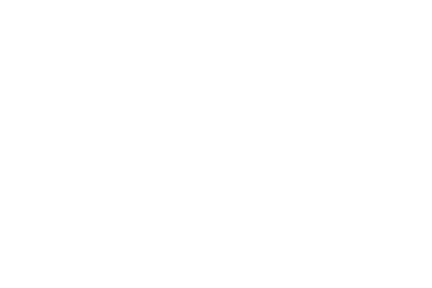

[[<Figure size 432x288 with 4 Axes>]]

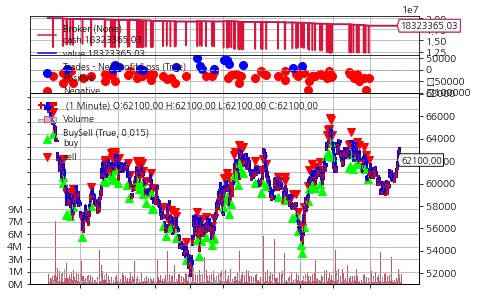

In [67]:
cerebro.plot(style='candle', barup='red', bardown='blue')